# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Define some functions for later '''
def count_consec(lst):
    consec = [1]
    for x, y in zip(lst, lst[1:]):
        if x == y - 1:
            consec[-1] += 1
        else:
            consec.append(1)
    return consec

def tuning_curve_bytrial(x, trial, Y, dt, b, sigma, smooth=True, normalize=False, occupancy=True):
    '''
    Params
    ------
    x : ndarray
        variable of interest by observation; shape (n_obs, )
    trial : ndarray
        trial num for each observation; shape (n_obs, )
    Y : ndarray
        spikes per observation; shape (n_obs, n_cells)
    dt : int
        time per observation in seconds
    b : int
        bin size
    sigma : int
        SD of Gaussian filter
    smooth : bool
        apply gaussian filter to firing rate; optional, default is True
    normalize : bool
        normalize the firing rate of each cell such that its max FR is 1, min is 0;
        optional, default is False
    occupancy : bool
        return occupancy (dwell time in each bin); optional, default is True

    Returns
    -------
    firing_rate : ndarray
        binned firing rate for each trial for each cell; shape (n_trials, n_bins, n_cells)
    centers : ndarray
        center of each bin
    occ : ndarray
       dwell time in each bin; shape (n_bins, n_cells)
    '''
    edges = np.arange(0, np.max(x) + b, b)
    centers = (edges[:-1] + edges[1:])/2
    b_idx = np.digitize(x, edges)
    if np.max(x) == edges[-1]:
        b_idx[b_idx==np.max(b_idx)] = np.max(b_idx) - 1
    unique_bdx = np.unique(b_idx)

    # find FR in each bin
    firing_rate = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    occ = np.zeros((np.unique(trial).shape[0], unique_bdx.shape[0], Y.shape[1]))
    for j in range(unique_bdx.shape[0]):
        idx1 = (b_idx == unique_bdx[j])
        for i, t in enumerate(np.unique(trial)):
            idx = idx1 & (trial == t)
            if np.sum(idx)==0:
                #print('warning: zero occupancy!')
                firing_rate[i, j, :] = firing_rate[i, j-1, :]
                occ[i, j, :] = 0
            else:    
                spike_ct = np.sum(Y[idx, :], axis=0)
                occupancy = dt * np.sum(idx)
                occ[i, j, :] = occupancy
                firing_rate[i, j, :] = spike_ct / occupancy
    if smooth:
        firing_rate = gaussian_filter1d(firing_rate, sigma, axis=1, mode='wrap')

    if normalize:
        for c in range(firing_rate.shape[2]):
            firing_rate[:, :, c] = (firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))/np.max(firing_rate[:, :, c] - np.min(firing_rate[:, :, c]))
    
    if occupancy:
        return firing_rate, centers, occ
    else: 
        return firing_rate, centers
    
def find8adjacentElements(test_list):
    ''' 
    Params
    ------
    test_list : ndarray
        1d array to be sorted
    
    Returns
    -------
    neighbors : list
        nested list where each element is a list of 8 adjacent elements to the element with the same 
        index in test_list, adjusting for the first and last four elements and not including 
    '''
    
    neighbors = []
    for idx, ele in enumerate(test_list):
    # Checking for all cases to append
        if idx == 0:
            neighbors.append(test_list[(idx+1):(idx + 9)])
        elif idx == 1:
            neighbors.append(np.concatenate((test_list[(idx - 1)],test_list[(idx+1):(idx + 8)]),axis=None))
        elif idx == 2:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 7)]),axis=None))
        elif idx == 3:
            neighbors.append(np.concatenate((test_list[:idx],test_list[(idx+1):(idx + 6)]),axis=None))
        elif idx == len(test_list) - 1:
            neighbors.append(np.concatenate((test_list[(idx-8):idx]),axis=None))                     
        elif idx == len(test_list) - 2:
            neighbors.append(np.concatenate((test_list[(idx-7):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 3:
            neighbors.append(np.concatenate((test_list[(idx-6):idx],test_list[(idx + 1):]),axis=None))
        elif idx == len(test_list) - 4:
            neighbors.append(np.concatenate((test_list[(idx-5):idx],test_list[(idx + 1):]),axis = None))
        else:
            neighbors.append(np.concatenate((test_list[(idx - 4):idx],test_list[(idx+1):(idx + 5)]),axis=None))
    return neighbors 

def find(x):
    return x.nonzero()[0]

def autocorr(x,lags):
    '''numpy.correlate'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

In [5]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [6]:
''' Complete List of Mice & Neural Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_1 excluded, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [7]:
'''Define which mice & sessions to load based on metadata'''
# Define mice, sessions for particular cohorts
mice , mice_ind, _  = np.intersect1d(all_mice, np.union1d(cohortc_mice, cohortd_mice), return_indices = True) # SM mice

sessions = []
for i in mice_ind:
    sessions.append(all_sessions[i])

# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

In [8]:
''' Get reward & lick data for sessions w/ neural data'''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook

#get lick & reward data
rewarda_centers = []
rewardb_centers = []

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
 
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        d['reward_data'] = {}
        
        # get behavioral params
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1) # fixes occassional Unity error numbering of rewards 
        
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
         # get reward params & remove reward data pertaining to dark trials & skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        auto_reward = np.array(reward['auto'][keep_idx])
        print('Mouse ' + m + ' with n_misses: ' + str(np.sum(misses)))   

        # get lick and reward indices
        lick_ct = get.spiketrain(post, dt, lickt, index=False)
        d['reward_data']['lick_ct'] = lick_ct
        print('got lick indices for mouse ' + m + ' session ' + s)
        
        reward_idx = get.rewardtrain(post, dt, rewardt, index=True) #gets reward ct for each time binned position range as index
        d['reward_data']['reward_idx'] = reward_idx
        print('got reward indices for mouse ' + m + ' session ' + s)
    
    # saves list of reward locations per mouse
    if reward['centers'][0] == 270:
        rewarda_centers = np.append(rewarda_centers,270)
        rewardb_centers = np.append(rewardb_centers,370)
    else:
        rewarda_centers = np.append(rewarda_centers,370)
        rewardb_centers = np.append(rewardb_centers,270)            

Skipped & dark trials omitted from reward data, n skipped = 3
Mouse A14 with n_misses: 183
got lick indices for mouse A14 session 083022_record1
got reward indices for mouse A14 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 11
Mouse A14 with n_misses: 154
got lick indices for mouse A14 session 083122_record2
got reward indices for mouse A14 session 083122_record2
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A14 with n_misses: 145
got lick indices for mouse A14 session 090122_record3
got reward indices for mouse A14 session 090122_record3
No trials skipped; only dark trials omitted from reward data
Mouse A15 with n_misses: 105
got lick indices for mouse A15 session 083022_record1
got reward indices for mouse A15 session 083022_record1
Skipped & dark trials omitted from reward data, n skipped = 1
Mouse A15 with n_misses: 80
got lick indices for mouse A15 session 083122_record2
got reward indices for mouse A15 session 083122_reco

No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 104
got lick indices for mouse A22 session 020223_record6
got reward indices for mouse A22 session 020223_record6
No trials skipped; only dark trials omitted from reward data
Mouse A22 with n_misses: 84
got lick indices for mouse A22 session 020323_record7
got reward indices for mouse A22 session 020323_record7
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 141
got lick indices for mouse A23 session 020923_record1
got reward indices for mouse A23 session 020923_record1
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 102
got lick indices for mouse A23 session 021023_record2
got reward indices for mouse A23 session 021023_record2
No trials skipped; only dark trials omitted from reward data
Mouse A23 with n_misses: 52
got lick indices for mouse A23 session 021123_record3
got reward indices for mouse A23 session 021123_record3
No

No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 46
got lick indices for mouse MA4M session 110322_record5rep
got reward indices for mouse MA4M session 110322_record5rep
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 15
got lick indices for mouse MA4M session 110422_record6
got reward indices for mouse MA4M session 110422_record6
No trials skipped; only dark trials omitted from reward data
Mouse MA4M with n_misses: 116
got lick indices for mouse MA4M session 110522_record7
got reward indices for mouse MA4M session 110522_record7
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 98
got lick indices for mouse MA5M session 110622_record1
got reward indices for mouse MA5M session 110622_record1
No trials skipped; only dark trials omitted from reward data
Mouse MA5M with n_misses: 89
got lick indices for mouse MA5M session 110722_record2
got reward indices for mouse MA5M sessio

No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 8
got lick indices for mouse Y21 session 092222_record5
got reward indices for mouse Y21 session 092222_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y21 with n_misses: 4
got lick indices for mouse Y21 session 092322_record6
got reward indices for mouse Y21 session 092322_record6
Skipped & dark trials omitted from reward data, n skipped = 3
Mouse Y22 with n_misses: 134
got lick indices for mouse Y22 session 092522_record1
got reward indices for mouse Y22 session 092522_record1
Skipped & dark trials omitted from reward data, n skipped = 23
Mouse Y22 with n_misses: 49
got lick indices for mouse Y22 session 092622_record2
got reward indices for mouse Y22 session 092622_record2
No trials skipped; only dark trials omitted from reward data
Mouse Y22 with n_misses: 24
got lick indices for mouse Y22 session 092722_record3
got reward indices for mouse Y22 session 092722_record3
Ski

No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 42
got lick indices for mouse Y28 session 030223_record5
got reward indices for mouse Y28 session 030223_record5
No trials skipped; only dark trials omitted from reward data
Mouse Y28 with n_misses: 36
got lick indices for mouse Y28 session 030323_record6
got reward indices for mouse Y28 session 030323_record6


In [9]:
''' Find & Save Number of Requested Rewards per Epoch per Session & Animal '''
#block array
blocksatiety = []
blockreq = []
blocktrialn = []

#session arrays
req_rates = []
reqa_rates = []
reqb_rates = []
reqblock_rates = []
reqalt_rates = []
reqalta_rates = []
reqaltb_rates = []
req_trials = []
reqblock_trials = []
reqalt_trials = []

#animals arrays
mreq_rates = []
mreqa_rates = []
mreqb_rates = []
mreqblock_rates = []
mreqalt_rates = []
mreqalta_rates = []
mreqaltb_rates = []

for m, session in zip(mice, sessions):
    rt = []
    ca = []
    cb = []
    blocks = []
    alt = []
    alta = []
    altb = []
    
    req = []
    reqa = []
    reqb = []
    reqblocks = []
    reqalt = []
    reqalta = []
    reqaltb = []
    
    for s in session:
        # get behavior data
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        posx = raw.item().get('posx')
        post = raw.item().get('post')
        dt = np.unique(np.round(np.diff(post),4))
        if len(dt) > 1: # discard duplicate frame entries if they occurred
            dt = dt[dt != 0]
        speed = raw.item().get('speed')
        
        # get reward params & remove reward data pertaining to dark trials & skipped trials
        lickt = raw.item().get('lickt')
        trials_dark = np.sum(raw.item().get('trialinfo')['dark'])
        reward = raw.item().get('reward')
        reward['trials'] = np.arange(0,len(reward['trials']),1)
        
        try:
            _ = raw.item().get('correctedtrial').shape
            trial = raw.item().get('correctedtrial')
            
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0,np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
                
            skippedtrials = np.setdiff1d(alltrial,np.unique(trial))
            nonskipped = np.setdiff1d(reward['trials'],skippedtrials)   
            k_idx = np.intersect1d(np.where(reward['trials'] > trials_dark), nonskipped)
            keep_idx = np.intersect1d(np.where(reward['trials'] <= np.max(alltrial)), k_idx)
            #print('Skipped & dark trials omitted from reward data, n skipped = ' + str(len(skippedtrials)))
            
        except AttributeError:
            trial = raw.item().get('trial')
            keep_idx = (np.where(reward['trials'] > trials_dark))
            skippedtrials = []
            #print('No trials skipped; only dark trials omitted from reward data')
        
        reward_centers = np.array(reward['centers'][keep_idx])
        rewarda = reward_centers[0]
        rewardb = reward_centers[60]
        rewardt = reward['times'][keep_idx]
        reward_trials = reward['trials'][keep_idx]
        misses = reward['missed'][keep_idx].astype(bool)
        requests = ~misses
        
        # find rate of requests for a given session
        req_rates.append(np.sum(requests)/len(reward_trials)) #total
        
        rewarda_idx = np.where(reward_trials < 81)[0]
        reqa_rates.append(np.sum(requests[rewarda_idx])/len(rewarda_idx)) #context a
        
        rewardb_idx = np.intersect1d((np.where(reward_trials >= 81)), (np.where(reward_trials <= 140)))
        reqb_rates.append(np.sum(requests[rewardb_idx])/len(rewardb_idx)) #context b
        
        block_idx = np.where(reward_trials < 140)[0]
        reqblock_rates.append(np.sum(requests[block_idx])/len(block_idx)) #block
        
        alt_idx = np.where(reward_trials >= 140)[0]
        reqalt_rates.append(np.sum(requests[alt_idx])/len(alt_idx)) #alt
        
        alta_idx = np.where((reward_trials >= 140) & (reward_centers == rewarda))[0] 
        reqalta_rates.append(np.mean(requests[alta_idx]))
        
        altb_idx = np.where((reward_trials >= 140) & (reward_centers == rewardb))[0]
        reqaltb_rates.append(np.mean(requests[altb_idx]))
        
        rt = np.append(rt,len(reward_trials))
        ca = np.append(ca,len(rewarda_idx))
        cb = np.append(cb,len(rewardb_idx))
        blocks = np.append(blocks,len(block_idx))
        alt = np.append(alt,len(alt_idx))
        alta = np.append(alta, len(alta_idx))
        altb = np.append(altb, len(altb_idx))
        
        req_trials = np.append(req_trials, len(reward_trials))
        reqblock_trials = np.append(reqblock_trials, len(block_idx))
        reqalt_trials = np.append(reqalt_trials, len(alt_idx))
        
        req = np.append(req,np.sum(requests))
        reqa = np.append(reqa,np.sum(requests[rewarda_idx]))
        reqb = np.append(reqb,np.sum(requests[rewardb_idx]))
        reqblocks = np.append(reqblocks,np.sum(requests[block_idx]))
        reqalt = np.append(reqalt,np.sum(requests[alt_idx]))
        reqalta = np.append(reqalta,requests[alta_idx])
        reqaltb = np.append(reqaltb,requests[altb_idx])
        
        d['altreqbytrial'] = requests[alt_idx]
        
        # append req rates from blocks into block req array len(4 x total sessions)
        blockreq = np.append(blockreq, np.mean(requests[rewarda_idx])) # block 1
        blockreq = np.append(blockreq, np.mean(requests[rewardb_idx])) # block 2
        blockreq = np.append(blockreq, np.mean(requests[alta_idx])) # block 3
        blockreq = np.append(blockreq, np.mean(requests[altb_idx])) # block 4   
        
        blocktrialn = np.append(blocktrialn, len(requests[rewarda_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[rewardb_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[alta_idx]))
        blocktrialn = np.append(blocktrialn, len(requests[altb_idx]))
        
        # append reward counts from previous task block into block satiety array len(4 x total sessions)
        blocksatiety = np.append(blocksatiety, 0) #no rewards before block a for every animal
        blocksatiety = np.append(blocksatiety, np.sum(requests[rewarda_idx])) # count of rewards consumed before block b
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]))) # before alta
        blocksatiety = np.append(blocksatiety, (np.sum(requests[rewarda_idx]) + np.sum(requests[rewardb_idx]) + np.sum(requests[alta_idx]))) # beforealtb             
                          
    # get mouse request rate collapsing days
    mreqrate = np.sum(req)/ np.sum(rt)
    mreq_rates = np.append(mreq_rates,mreqrate)
    
    mreqarate = np.sum(reqa) / np.sum(ca)
    mreqa_rates = np.append(mreqa_rates, mreqarate)
    
    mreqbrate = np.sum(reqb) / np.sum(cb)
    mreqb_rates = np.append(mreqb_rates, mreqbrate)
    
    mreqblockrate = np.sum(reqblocks) / np.sum(blocks)
    mreqblock_rates = np.append(mreqblock_rates, mreqblockrate)
    
    mreqaltrate = np.sum(reqalt) / np.sum(alt)
    mreqalt_rates = np.append(mreqalt_rates, mreqaltrate)
    
    mreqalta_rates = np.append(mreqalta_rates, np.mean(reqalta))
    mreqaltb_rates = np.append(mreqaltb_rates, np.mean(reqaltb))
    
# save as arrays to be safe
req_rates = np.asarray(req_rates)
reqa_rates = np.asarray(reqa_rates)
reqb_rates = np.asarray(reqb_rates)
reqblock_rates = np.asarray(reqblock_rates)
reqalt_rates = np.asarray(reqalt_rates)
reqalta_rates = np.asarray(reqalta_rates)
reqaltb_rates = np.asarray(reqaltb_rates)

mreq_rates = np.asarray(mreq_rates)
mreqa_rates = np.asarray(mreqa_rates)
mreqb_rates = np.asarray(mreqb_rates)
mreqblock_rates = np.asarray(mreqblock_rates)
mreqalt_rates = np.asarray(mreqalt_rates)
mreqalta_rates = np.asarray(reqalta_rates)
mreqaltb_rates = np.asarray(reqaltb_rates)

blocksatiety = np.asarray(blocksatiety)
blockreq = np.asarray(blockreq)
blocktrialn = np.asarray(blocktrialn)

In [10]:
''' Find & save indices corresponding to quarters of the task sorted by context, making sure skipped trials are excluded''' 

#adjust paths
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/indices/'

for m, session in zip(mice,sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #load data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)        
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        
        #define indices for first two quarters accounting for skipped trials
        start_idx = (np.where(trial >= 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        enda_idx = (np.where(trial <= 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        endb_idx = (np.where(trial <= 139)[0][-1]).astype(int) # last index before alternation
        Aidx = np.arange(start_idx, enda_idx + 1, 1)
        Bidx = np.arange(enda_idx + 1, endb_idx + 1, 1)
        
        #find context A / B trials in alternation, removing skipped trials
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
               
        A_trials = np.where((left == 1))[0]
        A_trials = list(A_trials[A_trials >= 140])
        B_trials = np.where((left == 0))[0]
        B_trials = list(B_trials[B_trials >= 140])
    
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            
        for n, t in enumerate(skippedtrials):
            if t in A_trials:
                A_trials.remove(t)
            elif t in B_trials:
                B_trials.remove(t)
    
        A_idx = []
        for t in A_trials:
            A_idx = np.append(A_idx, np.where(trial == t)[0])
            A_idx = A_idx.astype(int)
            
        B_idx = []
        for t in B_trials:
            B_idx = np.append(B_idx, np.where(trial == t)[0])
            B_idx = B_idx.astype(int)
            
        #save indices for session sections
        Aidx_file = 'Aidx_' + m + '_' + s +'.npy'
        Bidx_file = 'Bidx_' + m + '_' + s +'.npy'
        A_idx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_idx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        d['Aidx'] = Aidx
        d['Bidx'] = Bidx
        d['A_idx'] = A_idx
        d['B_idx'] = B_idx
        
        #np.save(save_folder + Aidx_file, Aidx)
        #np.save(save_folder + Bidx_file, Bidx)
        #np.save(save_folder + A_idx_file, A_idx)
        #np.save(save_folder + B_idx_file, B_idx)
        print('saved relevant data indices for future use') 
        
        # get non-gain change A' and B' indices 
        gain = trialinfo['gain']
        
        A_ngidx_file = 'A_idx_' + m + '_' + s +'.npy'
        B_ngidx_file = 'B_idx_' + m + '_' + s +'.npy'
        
        #check if mouse reached gain period; if not append NaN to all arrays & continue 
        if len(gain) < 200:
            print(str(m) + str(s) + ' did not reach gain change')
            
            d['A_ngidx'] = A_idx
            d['B_ngidx'] = B_idx
            
            np.save(save_folder + A_ngidx_file, A_idx)
            np.save(save_folder + B_ngidx_file, B_idx)
            
            continue 
            
        #get count of gain change trials in each context & select equal number of last Context A or B alt trials before gain
        gain_trials = np.where((gain == 0.7))[0]
        gain_trials = list(gain_trials)

        Agtrials = np.intersect1d(A_trials, np.asarray(gain_trials))
        Agtrials = list(np.sort(Agtrials.astype(int)))
        Bgtrials = np.intersect1d(B_trials, np.asarray(gain_trials))                   
        Bgtrials = list(np.sort(Bgtrials.astype(int)))
    
        #get indices of observations corresponding to the selected trials
        Agidx = []
        for t in Agtrials:
            Agidx = np.append(Agidx, np.where(trial == t)[0])
        Agidx = Agidx.astype(int)
            
        Bgidx = []
        for t in Bgtrials:
            Bgidx = np.append(Bgidx, np.where(trial == t)[0])
        Bgidx = Bgidx.astype(int)
        
        A_ngidx = np.setdiff1d(A_idx,Agidx).astype(int)
        B_ngidx = np.setdiff1d(B_idx,Bgidx).astype(int)
        
        d['A_ngidx'] = A_ngidx
        d['B_ngidx'] = B_ngidx
        
        np.save(save_folder + A_ngidx_file, A_ngidx)
        np.save(save_folder + B_ngidx_file, B_ngidx)
        
        print('saved gain adjusted alternation idx')


  0%|          | 0/3 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[ 6  7 83]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 11[ 39  40  41  74  75  76  77  78 108 127 180]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[160]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[168]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[130]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[ 29 144]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[161 164 165 166]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/4 [00:00<?, ?it/s]

Skipped trials, n skipped = 15[100 101 102 110 111 112 113 114 115 116 117 118 119 172 181]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[141 188 189 190]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 11[ 82 109 110 130 149 150 157 169 170 178 179]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[167]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 9[185 186 187 188 189 190 191 192 193]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 5[108 109 110 111 208]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[  5  87  88 100]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[132]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 4[177 178 179 180]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
A20013123_record6 did not reach gain change


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/4 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[120 121 122]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[127 128 143]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 3[169 170 171]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 23[105 106 107 108 109 110 111 112 113 114 138 139 140 141 142 143 144 145
 146 147 148 188 189]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[22]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[166 178]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[175 202]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[144]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 1[212]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[115 152]
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 3[ 21 161 177]
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

Skipped trials, n skipped = 2[137 138]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
Skipped trials, n skipped = 2[ 52 167]
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


  0%|          | 0/6 [00:00<?, ?it/s]

saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx
saved relevant data indices for future use
saved gain adjusted alternation idx


# Classify spatial cells using shuffle results OR skip to next section.

You'll only need to run this section only once in order to generate spatial cell booleans for these sessions.

In [10]:
''' Calculate & Save Spatial Coherence & Sparsity Scores for all Sessions '''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/' # adjust to desired output location
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' #adjust to output of Import/Filter notebook
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session, leave=False):
        d = data[m][s]
        
        #get data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        total_time = max(post) - min(post)
        
        #delineate contexta 
        start_idx = (np.where(trial == 20)[0][0]).astype(int) # trial is zero-indexed, 20 full dark trials
        end_idx = (np.where(trial == 79)[0][-1]).astype(int) # get indices of all 60 context_a trials that follow dark
        A = Y[start_idx:end_idx, :]
        aposxfil = posx[start_idx:end_idx]
        
        #get smoothed FR & sparsity scores 
        asmoothFR, _, asmoothocc = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=True, SEM=False, occupancy=True)
        aFR, _ , _ = ps.tuning_curve(aposxfil, A, dt, b = 2, l=2, smooth=False, SEM=False, occupancy=True)      
        
        #calculate sparsity with smoothed FR in Context A
        sparsitya_scores = []
        totala_time = max(post[start_idx:end_idx]) - min(post[start_idx:end_idx])
        for i, c in enumerate(cell_IDs):
            meanFRsqr = np.square(np.mean(asmoothFR[:,i]))
            products = []
            for b in range(asmoothFR.shape[0]):
                binmeanFRsqr = np.square(asmoothFR[b,i])
                prob = asmoothocc[b,i]/totala_time
                prod = prob * binmeanFRsqr
                products = np.append(products,prod)
            asparsity = np.sum(products) / meanFRsqr
            sparsitya_scores = np.append(sparsitya_scores,asparsity)
        d['spatialasparsity'] = sparsitya_scores

        # calculate spatial tuning coherence score with non-smoothed FR in Context A
        spatialacoherence_scores = []
        for i, c in enumerate(cell_IDs):
            neighbors = find8adjacentElements(aFR[:,i])
            meanFR_neighbors = []
            for b in range(aFR.shape[0]):
                meanFR_neigh = np.mean(neighbors[b])
                meanFR_neighbors = np.append(meanFR_neighbors, meanFR_neigh)
            acoherence, _ = stats.pearsonr(aFR[:,i],meanFR_neighbors)
            if math.isnan(acoherence):
                spatialacoherence_scores = np.append(spatialacoherence_scores,0)
            else:
                spatialacoherence_scores = np.append(spatialacoherence_scores,acoherence)
        d['spatialacoherencescores'] = spatialacoherence_scores
    
        #Get file names & save scores as npy files
        sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
        spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy'    
        
        #np.save(save_folder + sparsityascore_file, sparsitya_scores)
        print('saved sparsity A scores as npy file for mouse ' + m + ' session '+ s)

        #np.save(save_folder + spatialacoherencescore_file, spatialacoherence_scores)
        print('saved spatial coherence A scores as npy file for mouse ' + m + ' session '+ s)

  0%|          | 0/3 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A14 session 083022_record1
saved spatial coherence A scores as npy file for mouse A14 session 083022_record1
saved sparsity A scores as npy file for mouse A14 session 083122_record2
saved spatial coherence A scores as npy file for mouse A14 session 083122_record2
saved sparsity A scores as npy file for mouse A14 session 090122_record3
saved spatial coherence A scores as npy file for mouse A14 session 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A15 session 083022_record1
saved spatial coherence A scores as npy file for mouse A15 session 083022_record1


C:\Users\Python\AppData\Local\Temp\ipykernel_22264\715522461.py:46: RuntimeWarning: invalid value encountered in scalar divide
  asparsity = np.sum(products) / meanFRsqr
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


saved sparsity A scores as npy file for mouse A15 session 083122_record2
saved spatial coherence A scores as npy file for mouse A15 session 083122_record2
saved sparsity A scores as npy file for mouse A15 session 090122_record3
saved spatial coherence A scores as npy file for mouse A15 session 090122_record3
saved sparsity A scores as npy file for mouse A15 session 090222_record4
saved spatial coherence A scores as npy file for mouse A15 session 090222_record4
saved sparsity A scores as npy file for mouse A15 session 090322_record5
saved spatial coherence A scores as npy file for mouse A15 session 090322_record5
saved sparsity A scores as npy file for mouse A15 session 090422_record6
saved spatial coherence A scores as npy file for mouse A15 session 090422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A16 session 083022_record1
saved spatial coherence A scores as npy file for mouse A16 session 083022_record1
saved sparsity A scores as npy file for mouse A16 session 083122_record2
saved spatial coherence A scores as npy file for mouse A16 session 083122_record2
saved sparsity A scores as npy file for mouse A16 session 090122_record3
saved spatial coherence A scores as npy file for mouse A16 session 090122_record3
saved sparsity A scores as npy file for mouse A16 session 090222_record4
saved spatial coherence A scores as npy file for mouse A16 session 090222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A17 session 082322_record1
saved spatial coherence A scores as npy file for mouse A17 session 082322_record1
saved sparsity A scores as npy file for mouse A17 session 082422_record2
saved spatial coherence A scores as npy file for mouse A17 session 082422_record2
saved sparsity A scores as npy file for mouse A17 session 082522_record3
saved spatial coherence A scores as npy file for mouse A17 session 082522_record3
saved sparsity A scores as npy file for mouse A17 session 082622_record4
saved spatial coherence A scores as npy file for mouse A17 session 082622_record4
saved sparsity A scores as npy file for mouse A17 session 082722_record5
saved spatial coherence A scores as npy file for mouse A17 session 082722_record5
saved sparsity A scores as npy file for mouse A17 session 082822_record6
saved spatial coherence A scores as npy file for mouse A17 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A18 session 082322_record1real
saved spatial coherence A scores as npy file for mouse A18 session 082322_record1real
saved sparsity A scores as npy file for mouse A18 session 082422_record2
saved spatial coherence A scores as npy file for mouse A18 session 082422_record2
saved sparsity A scores as npy file for mouse A18 session 082522_record3
saved spatial coherence A scores as npy file for mouse A18 session 082522_record3
saved sparsity A scores as npy file for mouse A18 session 082622_record4
saved spatial coherence A scores as npy file for mouse A18 session 082622_record4
saved sparsity A scores as npy file for mouse A18 session 082722_record5
saved spatial coherence A scores as npy file for mouse A18 session 082722_record5
saved sparsity A scores as npy file for mouse A18 session 082822_record6
saved spatial coherence A scores as npy file for mouse A18 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A19 session 012723_record2
saved spatial coherence A scores as npy file for mouse A19 session 012723_record2
saved sparsity A scores as npy file for mouse A19 session 012823_record3
saved spatial coherence A scores as npy file for mouse A19 session 012823_record3
saved sparsity A scores as npy file for mouse A19 session 012923_record4
saved spatial coherence A scores as npy file for mouse A19 session 012923_record4
saved sparsity A scores as npy file for mouse A19 session 013023_record5
saved spatial coherence A scores as npy file for mouse A19 session 013023_record5
saved sparsity A scores as npy file for mouse A19 session 013123_record6
saved spatial coherence A scores as npy file for mouse A19 session 013123_record6
saved sparsity A scores as npy file for mouse A19 session 020123_record7
saved spatial coherence A scores as npy file for mouse A19 session 020123_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A20 session 012623_record1
saved spatial coherence A scores as npy file for mouse A20 session 012623_record1
saved sparsity A scores as npy file for mouse A20 session 012723_record2
saved spatial coherence A scores as npy file for mouse A20 session 012723_record2
saved sparsity A scores as npy file for mouse A20 session 012823_record3
saved spatial coherence A scores as npy file for mouse A20 session 012823_record3
saved sparsity A scores as npy file for mouse A20 session 012923_record4
saved spatial coherence A scores as npy file for mouse A20 session 012923_record4
saved sparsity A scores as npy file for mouse A20 session 013023_record5
saved spatial coherence A scores as npy file for mouse A20 session 013023_record5
saved sparsity A scores as npy file for mouse A20 session 013123_record6
saved spatial coherence A scores as npy file for mouse A20 session 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A22 session 012923_record2
saved spatial coherence A scores as npy file for mouse A22 session 012923_record2
saved sparsity A scores as npy file for mouse A22 session 013023_record3
saved spatial coherence A scores as npy file for mouse A22 session 013023_record3
saved sparsity A scores as npy file for mouse A22 session 013123_record4
saved spatial coherence A scores as npy file for mouse A22 session 013123_record4
saved sparsity A scores as npy file for mouse A22 session 020123_record5
saved spatial coherence A scores as npy file for mouse A22 session 020123_record5
saved sparsity A scores as npy file for mouse A22 session 020223_record6
saved spatial coherence A scores as npy file for mouse A22 session 020223_record6
saved sparsity A scores as npy file for mouse A22 session 020323_record7
saved spatial coherence A scores as npy file for mouse A22 session 020323_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A23 session 020923_record1
saved spatial coherence A scores as npy file for mouse A23 session 020923_record1
saved sparsity A scores as npy file for mouse A23 session 021023_record2
saved spatial coherence A scores as npy file for mouse A23 session 021023_record2
saved sparsity A scores as npy file for mouse A23 session 021123_record3
saved spatial coherence A scores as npy file for mouse A23 session 021123_record3
saved sparsity A scores as npy file for mouse A23 session 021223_record4
saved spatial coherence A scores as npy file for mouse A23 session 021223_record4
saved sparsity A scores as npy file for mouse A23 session 021323_record5
saved spatial coherence A scores as npy file for mouse A23 session 021323_record5
saved sparsity A scores as npy file for mouse A23 session 021423_record6
saved spatial coherence A scores as npy file for mouse A23 session 021423_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse A24 session 022623_record1
saved spatial coherence A scores as npy file for mouse A24 session 022623_record1
saved sparsity A scores as npy file for mouse A24 session 022723_record2
saved spatial coherence A scores as npy file for mouse A24 session 022723_record2
saved sparsity A scores as npy file for mouse A24 session 022823_record3
saved spatial coherence A scores as npy file for mouse A24 session 022823_record3
saved sparsity A scores as npy file for mouse A24 session 030123_record4
saved spatial coherence A scores as npy file for mouse A24 session 030123_record4
saved sparsity A scores as npy file for mouse A24 session 030223_record5
saved spatial coherence A scores as npy file for mouse A24 session 030223_record5
saved sparsity A scores as npy file for mouse A24 session 030323_record6
saved spatial coherence A scores as npy file for mouse A24 session 030323_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA10F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA10F session 111322_record1
saved sparsity A scores as npy file for mouse MA10F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA10F session 111422_record2
saved sparsity A scores as npy file for mouse MA10F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA10F session 111522_record3
saved sparsity A scores as npy file for mouse MA10F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA10F session 111622_record4
saved sparsity A scores as npy file for mouse MA10F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA10F session 111722_record5
saved sparsity A scores as npy file for mouse MA10F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA10F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA1F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA1F session 102322_record1
saved sparsity A scores as npy file for mouse MA1F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA1F session 102422_record2
saved sparsity A scores as npy file for mouse MA1F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA1F session 102522_record3
saved sparsity A scores as npy file for mouse MA1F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA1F session 102622_record4
saved sparsity A scores as npy file for mouse MA1F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA1F session 102722_record5
saved sparsity A scores as npy file for mouse MA1F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA1F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA2F session 102322_record1
saved spatial coherence A scores as npy file for mouse MA2F session 102322_record1
saved sparsity A scores as npy file for mouse MA2F session 102422_record2
saved spatial coherence A scores as npy file for mouse MA2F session 102422_record2
saved sparsity A scores as npy file for mouse MA2F session 102522_record3
saved spatial coherence A scores as npy file for mouse MA2F session 102522_record3
saved sparsity A scores as npy file for mouse MA2F session 102622_record4
saved spatial coherence A scores as npy file for mouse MA2F session 102622_record4
saved sparsity A scores as npy file for mouse MA2F session 102722_record5
saved spatial coherence A scores as npy file for mouse MA2F session 102722_record5
saved sparsity A scores as npy file for mouse MA2F session 102822_record6
saved spatial coherence A scores as npy file for mouse MA2F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA3M session 102322_record1
saved spatial coherence A scores as npy file for mouse MA3M session 102322_record1
saved sparsity A scores as npy file for mouse MA3M session 102422_record2
saved spatial coherence A scores as npy file for mouse MA3M session 102422_record2
saved sparsity A scores as npy file for mouse MA3M session 102522_record3
saved spatial coherence A scores as npy file for mouse MA3M session 102522_record3
saved sparsity A scores as npy file for mouse MA3M session 102622_record4
saved spatial coherence A scores as npy file for mouse MA3M session 102622_record4
saved sparsity A scores as npy file for mouse MA3M session 102722_record5
saved spatial coherence A scores as npy file for mouse MA3M session 102722_record5
saved sparsity A scores as npy file for mouse MA3M session 102822_record6
saved spatial coherence A scores as npy file for mouse MA3M session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA4M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA4M session 103122_record2
saved sparsity A scores as npy file for mouse MA4M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA4M session 110122_record3
saved sparsity A scores as npy file for mouse MA4M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA4M session 110222_record4
saved sparsity A scores as npy file for mouse MA4M session 110322_record5rep
saved spatial coherence A scores as npy file for mouse MA4M session 110322_record5rep
saved sparsity A scores as npy file for mouse MA4M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA4M session 110422_record6
saved sparsity A scores as npy file for mouse MA4M session 110522_record7
saved spatial coherence A scores as npy file for mouse MA4M session 110522_record7


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA5M session 110622_record1
saved spatial coherence A scores as npy file for mouse MA5M session 110622_record1
saved sparsity A scores as npy file for mouse MA5M session 110722_record2
saved spatial coherence A scores as npy file for mouse MA5M session 110722_record2
saved sparsity A scores as npy file for mouse MA5M session 110822_record3
saved spatial coherence A scores as npy file for mouse MA5M session 110822_record3
saved sparsity A scores as npy file for mouse MA5M session 110922_record4
saved spatial coherence A scores as npy file for mouse MA5M session 110922_record4
saved sparsity A scores as npy file for mouse MA5M session 111022_record5
saved spatial coherence A scores as npy file for mouse MA5M session 111022_record5
saved sparsity A scores as npy file for mouse MA5M session 111122_record6
saved spatial coherence A scores as npy file for mouse MA5M session 111122_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA6M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA6M session 103022_record1
saved sparsity A scores as npy file for mouse MA6M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA6M session 103122_record2
saved sparsity A scores as npy file for mouse MA6M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA6M session 110122_record3
saved sparsity A scores as npy file for mouse MA6M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA6M session 110222_record4
saved sparsity A scores as npy file for mouse MA6M session 110322_record5
saved spatial coherence A scores as npy file for mouse MA6M session 110322_record5
saved sparsity A scores as npy file for mouse MA6M session 110422_record6
saved spatial coherence A scores as npy file for mouse MA6M session 110422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA7M session 103022_record1
saved spatial coherence A scores as npy file for mouse MA7M session 103022_record1
saved sparsity A scores as npy file for mouse MA7M session 103122_record2
saved spatial coherence A scores as npy file for mouse MA7M session 103122_record2
saved sparsity A scores as npy file for mouse MA7M session 110122_record3
saved spatial coherence A scores as npy file for mouse MA7M session 110122_record3
saved sparsity A scores as npy file for mouse MA7M session 110222_record4
saved spatial coherence A scores as npy file for mouse MA7M session 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA8F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA8F session 111322_record1
saved sparsity A scores as npy file for mouse MA8F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA8F session 111422_record2
saved sparsity A scores as npy file for mouse MA8F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA8F session 111522_record3
saved sparsity A scores as npy file for mouse MA8F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA8F session 111622_record4
saved sparsity A scores as npy file for mouse MA8F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA8F session 111722_record5
saved sparsity A scores as npy file for mouse MA8F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA8F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse MA9F session 111322_record1
saved spatial coherence A scores as npy file for mouse MA9F session 111322_record1
saved sparsity A scores as npy file for mouse MA9F session 111422_record2
saved spatial coherence A scores as npy file for mouse MA9F session 111422_record2
saved sparsity A scores as npy file for mouse MA9F session 111522_record3
saved spatial coherence A scores as npy file for mouse MA9F session 111522_record3
saved sparsity A scores as npy file for mouse MA9F session 111622_record4
saved spatial coherence A scores as npy file for mouse MA9F session 111622_record4
saved sparsity A scores as npy file for mouse MA9F session 111722_record5
saved spatial coherence A scores as npy file for mouse MA9F session 111722_record5
saved sparsity A scores as npy file for mouse MA9F session 111822_record6
saved spatial coherence A scores as npy file for mouse MA9F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y20 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y20 session 092522_record1
saved sparsity A scores as npy file for mouse Y20 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y20 session 092622_record2
saved sparsity A scores as npy file for mouse Y20 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y20 session 092722_record3
saved sparsity A scores as npy file for mouse Y20 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y20 session 092822_record4
saved sparsity A scores as npy file for mouse Y20 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y20 session 092922_record5
saved sparsity A scores as npy file for mouse Y20 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y20 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y21 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y21 session 091822_record1
saved sparsity A scores as npy file for mouse Y21 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y21 session 091922_record2
saved sparsity A scores as npy file for mouse Y21 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y21 session 092022_record3
saved sparsity A scores as npy file for mouse Y21 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y21 session 092122_record4
saved sparsity A scores as npy file for mouse Y21 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y21 session 092222_record5
saved sparsity A scores as npy file for mouse Y21 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y21 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y22 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y22 session 092522_record1
saved sparsity A scores as npy file for mouse Y22 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y22 session 092622_record2
saved sparsity A scores as npy file for mouse Y22 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y22 session 092722_record3
saved sparsity A scores as npy file for mouse Y22 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y22 session 092822_record4
saved sparsity A scores as npy file for mouse Y22 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y22 session 092922_record5
saved sparsity A scores as npy file for mouse Y22 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y22 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y23 session 092522_record1
saved spatial coherence A scores as npy file for mouse Y23 session 092522_record1
saved sparsity A scores as npy file for mouse Y23 session 092622_record2
saved spatial coherence A scores as npy file for mouse Y23 session 092622_record2
saved sparsity A scores as npy file for mouse Y23 session 092722_record3
saved spatial coherence A scores as npy file for mouse Y23 session 092722_record3
saved sparsity A scores as npy file for mouse Y23 session 092822_record4
saved spatial coherence A scores as npy file for mouse Y23 session 092822_record4
saved sparsity A scores as npy file for mouse Y23 session 092922_record5
saved spatial coherence A scores as npy file for mouse Y23 session 092922_record5
saved sparsity A scores as npy file for mouse Y23 session 093022_record6
saved spatial coherence A scores as npy file for mouse Y23 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y24 session 091822_record1
saved spatial coherence A scores as npy file for mouse Y24 session 091822_record1
saved sparsity A scores as npy file for mouse Y24 session 091922_record2
saved spatial coherence A scores as npy file for mouse Y24 session 091922_record2
saved sparsity A scores as npy file for mouse Y24 session 092022_record3
saved spatial coherence A scores as npy file for mouse Y24 session 092022_record3
saved sparsity A scores as npy file for mouse Y24 session 092122_record4
saved spatial coherence A scores as npy file for mouse Y24 session 092122_record4
saved sparsity A scores as npy file for mouse Y24 session 092222_record5
saved spatial coherence A scores as npy file for mouse Y24 session 092222_record5
saved sparsity A scores as npy file for mouse Y24 session 092322_record6
saved spatial coherence A scores as npy file for mouse Y24 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y25 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y25 session 021623_record1
saved sparsity A scores as npy file for mouse Y25 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y25 session 021723_record2
saved sparsity A scores as npy file for mouse Y25 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y25 session 021823_record3
saved sparsity A scores as npy file for mouse Y25 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y25 session 021923_record4
saved sparsity A scores as npy file for mouse Y25 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y25 session 022023_record5
saved sparsity A scores as npy file for mouse Y25 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y25 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y26 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y26 session 021623_record1
saved sparsity A scores as npy file for mouse Y26 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y26 session 021723_record2
saved sparsity A scores as npy file for mouse Y26 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y26 session 021823_record3
saved sparsity A scores as npy file for mouse Y26 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y26 session 021923_record4
saved sparsity A scores as npy file for mouse Y26 session 022023_record5
saved spatial coherence A scores as npy file for mouse Y26 session 022023_record5
saved sparsity A scores as npy file for mouse Y26 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y26 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y27 session 021623_record1
saved spatial coherence A scores as npy file for mouse Y27 session 021623_record1
saved sparsity A scores as npy file for mouse Y27 session 021723_record2
saved spatial coherence A scores as npy file for mouse Y27 session 021723_record2
saved sparsity A scores as npy file for mouse Y27 session 021823_record3
saved spatial coherence A scores as npy file for mouse Y27 session 021823_record3
saved sparsity A scores as npy file for mouse Y27 session 021923_record4
saved spatial coherence A scores as npy file for mouse Y27 session 021923_record4
saved sparsity A scores as npy file for mouse Y27 session 022023_record5rep
saved spatial coherence A scores as npy file for mouse Y27 session 022023_record5rep
saved sparsity A scores as npy file for mouse Y27 session 022123_record6
saved spatial coherence A scores as npy file for mouse Y27 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

saved sparsity A scores as npy file for mouse Y28 session 022623_record1
saved spatial coherence A scores as npy file for mouse Y28 session 022623_record1
saved sparsity A scores as npy file for mouse Y28 session 022723_record2
saved spatial coherence A scores as npy file for mouse Y28 session 022723_record2
saved sparsity A scores as npy file for mouse Y28 session 022823_record3
saved spatial coherence A scores as npy file for mouse Y28 session 022823_record3
saved sparsity A scores as npy file for mouse Y28 session 030123_record4
saved spatial coherence A scores as npy file for mouse Y28 session 030123_record4
saved sparsity A scores as npy file for mouse Y28 session 030223_record5
saved spatial coherence A scores as npy file for mouse Y28 session 030223_record5
saved sparsity A scores as npy file for mouse Y28 session 030323_record6
saved spatial coherence A scores as npy file for mouse Y28 session 030323_record6


In [12]:
''' Load saved scores to classify spatial cells

Note : intn boolen & shuffled scores are produced by the notebook "Shuffle Procedure...." Please run that for all sessions before 
proceeding here or use saved scores in Dryad repository


'''
# adjust paths 
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/'
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/' # adjust to output of shuffle procedure notebook
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/' # adjust to desired output location

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
        shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load npy files       

        d['shuffsparsityascores'] = np.load(shuffload_folder1 + shufsparsityascore_file, allow_pickle=False)
        d['shuffspatialacoherencescores'] = np.load(shuffload_folder2 + shufspatialacoherencescore_file, allow_pickle=False)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)
        d['intn'] = d['intn'].astype(bool)

        
        try:
            _ = d['spatialasparsity'].shape
        except:
            print('loading previously generated sparsity & coherence scores...')
            sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
            spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 
            
            d['spatialasparsity'] = np.load(save_folder + sparsityascore_file, allow_pickle=True)
            d['spatialacoherencescores'] = np.load(save_folder + spatialacoherencescore_file, allow_pickle=True)

  0%|          | 0/3 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/4 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


  0%|          | 0/6 [00:00<?, ?it/s]

loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...
loading previously generated sparsity & coherence scores...


In [13]:
''' Gather total number of SM cells'''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
young_count = 0
MA_count = 0
age_count = 0

for m, session in zip(mice, sessions):
    for s in session:
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        if m in SM_aged_mice:
            age_count += len(cell_IDs)
        elif m in SM_MA_mice:
            MA_count += len(cell_IDs)
        else:
            young_count += len(cell_IDs)
            
print(young_count, MA_count, age_count)

15152 15011 13225


In [14]:
''' Classify Spatial Cells from Context A Sparsity & Coherence or skip to the next cell if you've done this before '''

load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'

per99c = []
per99s = []
dt = 0.02

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        post = behaviorfil[:,3]
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 
        intn = d['intn']

        #Classify spatial cells as those > P99 of both Contexte A shuffle sparsity & coherence score distributions
        spatialcell99 = []
        for i, c in enumerate(cell_IDs):

            dist1 = shuffspatialacoherencescores[:,i]
            P991 = np.nanpercentile(dist1,99)

            dist2 = shuffsparsityascores[:,i]
            P992 = np.nanpercentile(dist2,99)
            
            per99c.append(P991)
            per99s.append(P992)

            if intn[i] == True: #spatial cells must be excitatory
                spatialcell99 = np.append(spatialcell99, False)
            elif (spatialacoherence_scores[i] > P991) & (sparsitya_scores[i] > P992):
                spatialcell99 = np.append(spatialcell99, True)
            else:
                spatialcell99 = np.append(spatialcell99, False)
        spatialcell99 = np.asarray(spatialcell99).astype(bool)

        #save speed cell IDs in nested list for all animals
        d['spatialcell99'] = spatialcell99    
        print('% spatial cells = ' + str(100*len(cell_IDs[spatialcell99])/len(cell_IDs)))
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        #np.save(save_folder + spatialcell99_file, spatialcell99)
        print('saved spatial cell booleans as npy files for mouse ' + m + ' session '+ s)

print('\nMean ± SEM Coherence P99: ' + str(np.nanmean(per99c)) + ' ± ' + str(stats.sem(per99c, nan_policy = 'omit')))
print('Mean ± SEM Sparsity P99: ' + str(np.nanmean(per99s)) + ' ± ' + str(stats.sem(per99s,  nan_policy = 'omit'))) 

  0%|          | 0/3 [00:00<?, ?it/s]

% spatial cells = 31.944444444444443
saved spatial cell booleans as npy files for mouse A14 session 083022_record1
% spatial cells = 1.556420233463035
saved spatial cell booleans as npy files for mouse A14 session 083122_record2
% spatial cells = 26.881720430107528
saved spatial cell booleans as npy files for mouse A14 session 090122_record3


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 29.09090909090909
saved spatial cell booleans as npy files for mouse A15 session 083022_record1
% spatial cells = 54.225352112676056
saved spatial cell booleans as npy files for mouse A15 session 083122_record2
% spatial cells = 57.666666666666664
saved spatial cell booleans as npy files for mouse A15 session 090122_record3
% spatial cells = 45.154639175257735
saved spatial cell booleans as npy files for mouse A15 session 090222_record4
% spatial cells = 29.141104294478527
saved spatial cell booleans as npy files for mouse A15 session 090322_record5
% spatial cells = 29.82456140350877
saved spatial cell booleans as npy files for mouse A15 session 090422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

% spatial cells = 25.0
saved spatial cell booleans as npy files for mouse A16 session 083022_record1
% spatial cells = 56.41025641025641
saved spatial cell booleans as npy files for mouse A16 session 083122_record2
% spatial cells = 10.81081081081081
saved spatial cell booleans as npy files for mouse A16 session 090122_record3
% spatial cells = 34.07821229050279
saved spatial cell booleans as npy files for mouse A16 session 090222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 4.371584699453552
saved spatial cell booleans as npy files for mouse A17 session 082322_record1
% spatial cells = 19.444444444444443
saved spatial cell booleans as npy files for mouse A17 session 082422_record2
% spatial cells = 45.333333333333336
saved spatial cell booleans as npy files for mouse A17 session 082522_record3
% spatial cells = 47.239263803680984
saved spatial cell booleans as npy files for mouse A17 session 082622_record4
% spatial cells = 14.20911528150134
saved spatial cell booleans as npy files for mouse A17 session 082722_record5
% spatial cells = 48.91304347826087
saved spatial cell booleans as npy files for mouse A17 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 53.84615384615385
saved spatial cell booleans as npy files for mouse A18 session 082322_record1real
% spatial cells = 47.95539033457249
saved spatial cell booleans as npy files for mouse A18 session 082422_record2
% spatial cells = 51.58102766798419
saved spatial cell booleans as npy files for mouse A18 session 082522_record3
% spatial cells = 24.03697996918336
saved spatial cell booleans as npy files for mouse A18 session 082622_record4
% spatial cells = 31.718061674008812
saved spatial cell booleans as npy files for mouse A18 session 082722_record5
% spatial cells = 2.42914979757085
saved spatial cell booleans as npy files for mouse A18 session 082822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 1.0033444816053512
saved spatial cell booleans as npy files for mouse A19 session 012723_record2
% spatial cells = 42.55952380952381
saved spatial cell booleans as npy files for mouse A19 session 012823_record3
% spatial cells = 44.77124183006536
saved spatial cell booleans as npy files for mouse A19 session 012923_record4
% spatial cells = 43.93939393939394
saved spatial cell booleans as npy files for mouse A19 session 013023_record5
% spatial cells = 49.740932642487046
saved spatial cell booleans as npy files for mouse A19 session 013123_record6
% spatial cells = 46.829268292682926
saved spatial cell booleans as npy files for mouse A19 session 020123_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.181818181818183
saved spatial cell booleans as npy files for mouse A20 session 012623_record1
% spatial cells = 43.47826086956522
saved spatial cell booleans as npy files for mouse A20 session 012723_record2
% spatial cells = 45.063291139240505
saved spatial cell booleans as npy files for mouse A20 session 012823_record3
% spatial cells = 47.023809523809526
saved spatial cell booleans as npy files for mouse A20 session 012923_record4
% spatial cells = 40.16393442622951
saved spatial cell booleans as npy files for mouse A20 session 013023_record5
% spatial cells = 27.918781725888326
saved spatial cell booleans as npy files for mouse A20 session 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 58.100558659217874
saved spatial cell booleans as npy files for mouse A22 session 012923_record2
% spatial cells = 61.28133704735376
saved spatial cell booleans as npy files for mouse A22 session 013023_record3
% spatial cells = 53.588516746411486
saved spatial cell booleans as npy files for mouse A22 session 013123_record4
% spatial cells = 20.114942528735632
saved spatial cell booleans as npy files for mouse A22 session 020123_record5
% spatial cells = 43.21608040201005
saved spatial cell booleans as npy files for mouse A22 session 020223_record6
% spatial cells = 13.488372093023257
saved spatial cell booleans as npy files for mouse A22 session 020323_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 39.02439024390244
saved spatial cell booleans as npy files for mouse A23 session 020923_record1
% spatial cells = 34.375
saved spatial cell booleans as npy files for mouse A23 session 021023_record2
% spatial cells = 38.38709677419355
saved spatial cell booleans as npy files for mouse A23 session 021123_record3
% spatial cells = 12.5
saved spatial cell booleans as npy files for mouse A23 session 021223_record4
% spatial cells = 54.48717948717949
saved spatial cell booleans as npy files for mouse A23 session 021323_record5
% spatial cells = 56.578947368421055
saved spatial cell booleans as npy files for mouse A23 session 021423_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 42.758620689655174
saved spatial cell booleans as npy files for mouse A24 session 022623_record1
% spatial cells = 52.43619489559165
saved spatial cell booleans as npy files for mouse A24 session 022723_record2
% spatial cells = 50.755287009063444
saved spatial cell booleans as npy files for mouse A24 session 022823_record3
% spatial cells = 59.82532751091703
saved spatial cell booleans as npy files for mouse A24 session 030123_record4
% spatial cells = 56.42458100558659
saved spatial cell booleans as npy files for mouse A24 session 030223_record5
% spatial cells = 58.8235294117647
saved spatial cell booleans as npy files for mouse A24 session 030323_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 40.459363957597176
saved spatial cell booleans as npy files for mouse MA10F session 111322_record1
% spatial cells = 32.712765957446805
saved spatial cell booleans as npy files for mouse MA10F session 111422_record2
% spatial cells = 24.458204334365327
saved spatial cell booleans as npy files for mouse MA10F session 111522_record3
% spatial cells = 30.80168776371308
saved spatial cell booleans as npy files for mouse MA10F session 111622_record4
% spatial cells = 36.809815950920246
saved spatial cell booleans as npy files for mouse MA10F session 111722_record5
% spatial cells = 30.493273542600896
saved spatial cell booleans as npy files for mouse MA10F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 58.71559633027523
saved spatial cell booleans as npy files for mouse MA1F session 102322_record1
% spatial cells = 48.78048780487805
saved spatial cell booleans as npy files for mouse MA1F session 102422_record2
% spatial cells = 36.417910447761194
saved spatial cell booleans as npy files for mouse MA1F session 102522_record3
% spatial cells = 31.57894736842105
saved spatial cell booleans as npy files for mouse MA1F session 102622_record4
% spatial cells = 53.98550724637681
saved spatial cell booleans as npy files for mouse MA1F session 102722_record5
% spatial cells = 40.273972602739725
saved spatial cell booleans as npy files for mouse MA1F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 47.95539033457249
saved spatial cell booleans as npy files for mouse MA2F session 102322_record1
% spatial cells = 48.734177215189874
saved spatial cell booleans as npy files for mouse MA2F session 102422_record2
% spatial cells = 49.29245283018868
saved spatial cell booleans as npy files for mouse MA2F session 102522_record3
% spatial cells = 55.39033457249071
saved spatial cell booleans as npy files for mouse MA2F session 102622_record4
% spatial cells = 47.234042553191486
saved spatial cell booleans as npy files for mouse MA2F session 102722_record5
% spatial cells = 43.29896907216495
saved spatial cell booleans as npy files for mouse MA2F session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 32.98969072164948
saved spatial cell booleans as npy files for mouse MA3M session 102322_record1
% spatial cells = 37.878787878787875
saved spatial cell booleans as npy files for mouse MA3M session 102422_record2
% spatial cells = 25.136612021857925
saved spatial cell booleans as npy files for mouse MA3M session 102522_record3
% spatial cells = 47.752808988764045
saved spatial cell booleans as npy files for mouse MA3M session 102622_record4
% spatial cells = 50.0
saved spatial cell booleans as npy files for mouse MA3M session 102722_record5
% spatial cells = 51.578947368421055
saved spatial cell booleans as npy files for mouse MA3M session 102822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 42.04081632653061
saved spatial cell booleans as npy files for mouse MA4M session 103122_record2
% spatial cells = 49.24242424242424
saved spatial cell booleans as npy files for mouse MA4M session 110122_record3
% spatial cells = 41.0958904109589
saved spatial cell booleans as npy files for mouse MA4M session 110222_record4
% spatial cells = 47.10144927536232
saved spatial cell booleans as npy files for mouse MA4M session 110322_record5rep
% spatial cells = 21.700879765395893
saved spatial cell booleans as npy files for mouse MA4M session 110422_record6
% spatial cells = 20.833333333333332
saved spatial cell booleans as npy files for mouse MA4M session 110522_record7


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 27.018633540372672
saved spatial cell booleans as npy files for mouse MA5M session 110622_record1
% spatial cells = 30.174081237911025
saved spatial cell booleans as npy files for mouse MA5M session 110722_record2
% spatial cells = 27.30627306273063
saved spatial cell booleans as npy files for mouse MA5M session 110822_record3
% spatial cells = 51.21951219512195
saved spatial cell booleans as npy files for mouse MA5M session 110922_record4
% spatial cells = 40.104166666666664
saved spatial cell booleans as npy files for mouse MA5M session 111022_record5
% spatial cells = 39.375
saved spatial cell booleans as npy files for mouse MA5M session 111122_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 38.39009287925697
saved spatial cell booleans as npy files for mouse MA6M session 103022_record1
% spatial cells = 34.55882352941177
saved spatial cell booleans as npy files for mouse MA6M session 103122_record2
% spatial cells = 46.31268436578171
saved spatial cell booleans as npy files for mouse MA6M session 110122_record3
% spatial cells = 30.0
saved spatial cell booleans as npy files for mouse MA6M session 110222_record4
% spatial cells = 41.791044776119406
saved spatial cell booleans as npy files for mouse MA6M session 110322_record5
% spatial cells = 52.46913580246913
saved spatial cell booleans as npy files for mouse MA6M session 110422_record6


  0%|          | 0/4 [00:00<?, ?it/s]

% spatial cells = 30.088495575221238
saved spatial cell booleans as npy files for mouse MA7M session 103022_record1
% spatial cells = 42.53731343283582
saved spatial cell booleans as npy files for mouse MA7M session 103122_record2
% spatial cells = 38.72549019607843
saved spatial cell booleans as npy files for mouse MA7M session 110122_record3
% spatial cells = 10.15625
saved spatial cell booleans as npy files for mouse MA7M session 110222_record4


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.09917355371901
saved spatial cell booleans as npy files for mouse MA8F session 111322_record1
% spatial cells = 50.43988269794721
saved spatial cell booleans as npy files for mouse MA8F session 111422_record2
% spatial cells = 49.33774834437086
saved spatial cell booleans as npy files for mouse MA8F session 111522_record3
% spatial cells = 51.445086705202314
saved spatial cell booleans as npy files for mouse MA8F session 111622_record4
% spatial cells = 34.06113537117904
saved spatial cell booleans as npy files for mouse MA8F session 111722_record5
% spatial cells = 35.25179856115108
saved spatial cell booleans as npy files for mouse MA8F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 23.123732251521297
saved spatial cell booleans as npy files for mouse MA9F session 111322_record1
% spatial cells = 50.687285223367695
saved spatial cell booleans as npy files for mouse MA9F session 111422_record2
% spatial cells = 40.03868471953578
saved spatial cell booleans as npy files for mouse MA9F session 111522_record3
% spatial cells = 6.837606837606837
saved spatial cell booleans as npy files for mouse MA9F session 111622_record4
% spatial cells = 37.59398496240601
saved spatial cell booleans as npy files for mouse MA9F session 111722_record5
% spatial cells = 36.231884057971016
saved spatial cell booleans as npy files for mouse MA9F session 111822_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 27.11864406779661
saved spatial cell booleans as npy files for mouse Y20 session 092522_record1
% spatial cells = 69.33333333333333
saved spatial cell booleans as npy files for mouse Y20 session 092622_record2
% spatial cells = 17.2972972972973
saved spatial cell booleans as npy files for mouse Y20 session 092722_record3
% spatial cells = 64.15094339622641
saved spatial cell booleans as npy files for mouse Y20 session 092822_record4
% spatial cells = 67.3076923076923
saved spatial cell booleans as npy files for mouse Y20 session 092922_record5
% spatial cells = 64.11042944785277
saved spatial cell booleans as npy files for mouse Y20 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 47.57281553398058
saved spatial cell booleans as npy files for mouse Y21 session 091822_record1
% spatial cells = 43.84920634920635
saved spatial cell booleans as npy files for mouse Y21 session 091922_record2
% spatial cells = 31.384615384615383
saved spatial cell booleans as npy files for mouse Y21 session 092022_record3
% spatial cells = 39.573459715639814
saved spatial cell booleans as npy files for mouse Y21 session 092122_record4
% spatial cells = 29.12621359223301
saved spatial cell booleans as npy files for mouse Y21 session 092222_record5
% spatial cells = 12.162162162162161
saved spatial cell booleans as npy files for mouse Y21 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 56.838905775075986
saved spatial cell booleans as npy files for mouse Y22 session 092522_record1
% spatial cells = 53.46534653465346
saved spatial cell booleans as npy files for mouse Y22 session 092622_record2
% spatial cells = 54.24657534246575
saved spatial cell booleans as npy files for mouse Y22 session 092722_record3
% spatial cells = 38.764044943820224
saved spatial cell booleans as npy files for mouse Y22 session 092822_record4
% spatial cells = 56.75675675675676
saved spatial cell booleans as npy files for mouse Y22 session 092922_record5
% spatial cells = 59.06976744186046
saved spatial cell booleans as npy files for mouse Y22 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 18.133333333333333
saved spatial cell booleans as npy files for mouse Y23 session 092522_record1
% spatial cells = 10.217755443886098
saved spatial cell booleans as npy files for mouse Y23 session 092622_record2
% spatial cells = 27.210884353741495
saved spatial cell booleans as npy files for mouse Y23 session 092722_record3
% spatial cells = 57.85123966942149
saved spatial cell booleans as npy files for mouse Y23 session 092822_record4
% spatial cells = 60.32608695652174
saved spatial cell booleans as npy files for mouse Y23 session 092922_record5
% spatial cells = 51.60349854227405
saved spatial cell booleans as npy files for mouse Y23 session 093022_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 59.7667638483965
saved spatial cell booleans as npy files for mouse Y24 session 091822_record1
% spatial cells = 28.143712574850298
saved spatial cell booleans as npy files for mouse Y24 session 091922_record2
% spatial cells = 44.28223844282238
saved spatial cell booleans as npy files for mouse Y24 session 092022_record3
% spatial cells = 43.57298474945534
saved spatial cell booleans as npy files for mouse Y24 session 092122_record4
% spatial cells = 63.888888888888886
saved spatial cell booleans as npy files for mouse Y24 session 092222_record5
% spatial cells = 63.12056737588652
saved spatial cell booleans as npy files for mouse Y24 session 092322_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 28.571428571428573
saved spatial cell booleans as npy files for mouse Y25 session 021623_record1
% spatial cells = 41.76136363636363
saved spatial cell booleans as npy files for mouse Y25 session 021723_record2
% spatial cells = 33.03030303030303
saved spatial cell booleans as npy files for mouse Y25 session 021823_record3
% spatial cells = 36.271186440677965
saved spatial cell booleans as npy files for mouse Y25 session 021923_record4
% spatial cells = 33.43195266272189
saved spatial cell booleans as npy files for mouse Y25 session 022023_record5
% spatial cells = 15.41095890410959
saved spatial cell booleans as npy files for mouse Y25 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 50.62761506276151
saved spatial cell booleans as npy files for mouse Y26 session 021623_record1
% spatial cells = 35.670731707317074
saved spatial cell booleans as npy files for mouse Y26 session 021723_record2
% spatial cells = 38.857142857142854
saved spatial cell booleans as npy files for mouse Y26 session 021823_record3
% spatial cells = 40.0
saved spatial cell booleans as npy files for mouse Y26 session 021923_record4
% spatial cells = 32.369942196531795
saved spatial cell booleans as npy files for mouse Y26 session 022023_record5
% spatial cells = 15.533980582524272
saved spatial cell booleans as npy files for mouse Y26 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 56.0
saved spatial cell booleans as npy files for mouse Y27 session 021623_record1
% spatial cells = 42.24598930481283
saved spatial cell booleans as npy files for mouse Y27 session 021723_record2
% spatial cells = 46.15384615384615
saved spatial cell booleans as npy files for mouse Y27 session 021823_record3
% spatial cells = 38.46153846153846
saved spatial cell booleans as npy files for mouse Y27 session 021923_record4
% spatial cells = 51.470588235294116
saved spatial cell booleans as npy files for mouse Y27 session 022023_record5rep
% spatial cells = 44.688644688644686
saved spatial cell booleans as npy files for mouse Y27 session 022123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

% spatial cells = 31.11111111111111
saved spatial cell booleans as npy files for mouse Y28 session 022623_record1
% spatial cells = 32.33695652173913
saved spatial cell booleans as npy files for mouse Y28 session 022723_record2
% spatial cells = 24.541284403669724
saved spatial cell booleans as npy files for mouse Y28 session 022823_record3
% spatial cells = 31.73913043478261
saved spatial cell booleans as npy files for mouse Y28 session 030123_record4
% spatial cells = 39.7489539748954
saved spatial cell booleans as npy files for mouse Y28 session 030223_record5
% spatial cells = 33.093525179856115
saved spatial cell booleans as npy files for mouse Y28 session 030323_record6

Mean ± SEM Coherence P99: 0.4700406644214617 ± 0.0008567357640418019
Mean ± SEM Sparsity P99: 1.9894113166497576 ± 0.02421749243843613


In [15]:
''' If you skipped the cell above, load spatial cell and intn booleans. '''

#adjujst paths
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/'
shuffle_folder = 'C:/Users/Python/Desktop/LocalData/intnspeedcells/'

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #get file names
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'
        intn_file = 'intn_' + m + '_' + s + '.npy'

        #load stuff
        d['spatialcell99'] = np.load(save_folder + spatialcell99_file, allow_pickle = True)
        d['intn'] = np.load(shuffle_folder + intn_file, allow_pickle = True)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
''' Apply FR thresholds to spatial cells

Run time < 1 min / session (167 sessions)

'''

track_length = 400 #cm
b = 2 # cm / spatial bin
dt = 0.02
n_dark = 20 #trials
lags = np.arange(0,801,1)

#adjust paths
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/peakheights/'

perngs = []
pergrid = []
for m, session in zip(mice,sessions):
    
    for s in tdqm(session):
        
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        
        posxfil = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        trials = np.unique(trial)
        postfil = behaviorfil[:,3]
        rawtrialfil = raw.item().get('trialfil')
        
        Aidx = d['Aidx']
        Bidx = d['Bidx']
        
        #load in spatial cells & interneurons classified elsewhere
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        intn = d['intn']
        
        #define low FR cell group (mean FR <0.05 in the dark; 0.3 Hz overall); to be removed from grid cell group
        stop_idx = np.where(trial <= 19)[0][-1].astype(int)
        darkFR, _ , _ = ps.tuning_curve_bytrial(posxfil[:stop_idx], trial[:stop_idx], Y[:stop_idx,:], dt, b = 2, smooth=True, normalize=False, occupancy=True)
        FR, _, _ = ps.tuning_curve(posxfil, Y, dt, b, smooth=True, l=2, SEM=False, occupancy=False)
        lowfrcells = []
        lowdarkfrcells = []
        for i, c in enumerate(cell_IDs):
            if np.mean(np.mean(darkFR[:,:,i], axis = 1)) <= 0.05:
                lowdarkfrcells = np.append(lowdarkfrcells, c)
            elif np.mean(FR[:,i]) < 0.3:
                lowfrcells = np.append(lowfrcells, c)      
                
        #define indices excluding reward zone starts
        reward = raw.item().get('reward')
        centers = reward['centers']
        centera = centers[0]
        if centera == 270:
            centerb = 370
        else:
            centerb = 270
        
        # generate aligned position tuning curve
        aFR, abinned_pos, aFR_sem, occ = ps.tuning_curve(posxfil[Aidx], Y[Aidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        bFR, bbinned_pos, bFR_sem, occ = ps.tuning_curve(posxfil[Bidx], Y[Bidx,:], dt, b=2, smooth = True, l=5, SEM=True)
        
        #find indices of bins not including 50cm pre-post reward centers (220 to 255 and 320 to 355)
        aidx = np.where((abinned_pos > (centera - 50)) & (abinned_pos <= (centera - 15)))
        maska = np.ones(len(abinned_pos), bool)
        maska[aidx] = 0
        bidx = np.where((bbinned_pos > (centerb - 50)) & (bbinned_pos <= (centerb - 15)))
        maskb = np.ones(len(bbinned_pos), bool)
        maskb[bidx] = 0
        
        noisycells = []
        for i, c in enumerate(cell_IDs):
            if (np.mean(aFR_sem[maska,i]) > np.mean(aFR[maska,i])*.45) and (np.mean(bFR_sem[maskb,i]) > np.mean(bFR[maskb,i])*.45):
                noisycells = np.append(noisycells, c)
                
        # filter out noisy cells from both grid and ngs cells and low firing grid cells    
        for i, c in enumerate(cell_IDs):
            #also require that dark FR > 0.05 Hz and mean FR > 0.3 Hz
            if (c in lowfrcells) or (c in lowdarkfrcells):
                spatialcell99[i] = 0
                
            if (c in noisycells):
                spatialcell99[i] = 0
                spatialcell99[i] = 0
                
        #Save booleans
        spatialcell99 = spatialcell99.astype(bool)
        d['spatialcell99'] = spatialcell99

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

# Assess density of spatial cells.

In [27]:
''' Load saved spatial cell booleans & glance at overall density '''

save_folder = 'C:/Users/Python/Desktop/LocalData/shuffscores/'

perspatial = []
sperspatial = []
mperspatial = []

for m, session in zip(mice,sessions):
    
    m_perspatial = []
    m_cells = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #load in data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        spatialcell = d['spatialcell99'].astype(bool)
        
        print(m + ', ' + s + ' n spatial cells: '+ str(np.sum(spatialcell)))
        perspatial = np.append(perspatial, 100*np.sum(spatialcell)/len(cell_IDs))        
        sperspatial = np.append(sperspatial, 100*np.sum(spatialcell)/len(cell_IDs))
        m_perspatial = np.append(m_perspatial, np.sum(spatialcell))
        m_cells = np.append(m_cells, len(cell_IDs))
    
    mperspatial = np.append(mperspatial, np.sum(m_perspatial)/np.sum(m_cells)*100)

  0%|          | 0/3 [00:00<?, ?it/s]

A14, 083022_record1 n spatial cells: 67
A14, 083122_record2 n spatial cells: 4
A14, 090122_record3 n spatial cells: 24


  0%|          | 0/6 [00:00<?, ?it/s]

A15, 083022_record1 n spatial cells: 10
A15, 083122_record2 n spatial cells: 116
A15, 090122_record3 n spatial cells: 128
A15, 090222_record4 n spatial cells: 182
A15, 090322_record5 n spatial cells: 74
A15, 090422_record6 n spatial cells: 40


  0%|          | 0/4 [00:00<?, ?it/s]

A16, 083022_record1 n spatial cells: 44
A16, 083122_record2 n spatial cells: 93
A16, 090122_record3 n spatial cells: 4
A16, 090222_record4 n spatial cells: 52


  0%|          | 0/6 [00:00<?, ?it/s]

A17, 082322_record1 n spatial cells: 3
A17, 082422_record2 n spatial cells: 6
A17, 082522_record3 n spatial cells: 71
A17, 082622_record4 n spatial cells: 58
A17, 082722_record5 n spatial cells: 40
A17, 082822_record6 n spatial cells: 72


  0%|          | 0/6 [00:00<?, ?it/s]

A18, 082322_record1real n spatial cells: 30
A18, 082422_record2 n spatial cells: 229
A18, 082522_record3 n spatial cells: 198
A18, 082622_record4 n spatial cells: 113
A18, 082722_record5 n spatial cells: 59
A18, 082822_record6 n spatial cells: 5


  0%|          | 0/6 [00:00<?, ?it/s]

A19, 012723_record2 n spatial cells: 1
A19, 012823_record3 n spatial cells: 106
A19, 012923_record4 n spatial cells: 116
A19, 013023_record5 n spatial cells: 91
A19, 013123_record6 n spatial cells: 65
A19, 020123_record7 n spatial cells: 81


  0%|          | 0/6 [00:00<?, ?it/s]

A20, 012623_record1 n spatial cells: 25
A20, 012723_record2 n spatial cells: 72
A20, 012823_record3 n spatial cells: 117
A20, 012923_record4 n spatial cells: 59
A20, 013023_record5 n spatial cells: 75
A20, 013123_record6 n spatial cells: 41


  0%|          | 0/6 [00:00<?, ?it/s]

A22, 012923_record2 n spatial cells: 95
A22, 013023_record3 n spatial cells: 192
A22, 013123_record4 n spatial cells: 96
A22, 020123_record5 n spatial cells: 20
A22, 020223_record6 n spatial cells: 68
A22, 020323_record7 n spatial cells: 17


  0%|          | 0/6 [00:00<?, ?it/s]

A23, 020923_record1 n spatial cells: 13
A23, 021023_record2 n spatial cells: 85
A23, 021123_record3 n spatial cells: 89
A23, 021223_record4 n spatial cells: 10
A23, 021323_record5 n spatial cells: 64
A23, 021423_record6 n spatial cells: 103


  0%|          | 0/6 [00:00<?, ?it/s]

A24, 022623_record1 n spatial cells: 91
A24, 022723_record2 n spatial cells: 189
A24, 022823_record3 n spatial cells: 122
A24, 030123_record4 n spatial cells: 100
A24, 030223_record5 n spatial cells: 81
A24, 030323_record6 n spatial cells: 37


  0%|          | 0/6 [00:00<?, ?it/s]

MA10F, 111322_record1 n spatial cells: 142
MA10F, 111422_record2 n spatial cells: 93
MA10F, 111522_record3 n spatial cells: 59
MA10F, 111622_record4 n spatial cells: 41
MA10F, 111722_record5 n spatial cells: 38
MA10F, 111822_record6 n spatial cells: 85


  0%|          | 0/6 [00:00<?, ?it/s]

MA1F, 102322_record1 n spatial cells: 54
MA1F, 102422_record2 n spatial cells: 79
MA1F, 102522_record3 n spatial cells: 75
MA1F, 102622_record4 n spatial cells: 19
MA1F, 102722_record5 n spatial cells: 117
MA1F, 102822_record6 n spatial cells: 100


  0%|          | 0/6 [00:00<?, ?it/s]

MA2F, 102322_record1 n spatial cells: 112
MA2F, 102422_record2 n spatial cells: 128
MA2F, 102522_record3 n spatial cells: 146
MA2F, 102622_record4 n spatial cells: 102
MA2F, 102722_record5 n spatial cells: 73
MA2F, 102822_record6 n spatial cells: 85


  0%|          | 0/6 [00:00<?, ?it/s]

MA3M, 102322_record1 n spatial cells: 25
MA3M, 102422_record2 n spatial cells: 96
MA3M, 102522_record3 n spatial cells: 64
MA3M, 102622_record4 n spatial cells: 68
MA3M, 102722_record5 n spatial cells: 40
MA3M, 102822_record6 n spatial cells: 67


  0%|          | 0/6 [00:00<?, ?it/s]

MA4M, 103122_record2 n spatial cells: 91
MA4M, 110122_record3 n spatial cells: 54
MA4M, 110222_record4 n spatial cells: 19
MA4M, 110322_record5rep n spatial cells: 43
MA4M, 110422_record6 n spatial cells: 51
MA4M, 110522_record7 n spatial cells: 17


  0%|          | 0/6 [00:00<?, ?it/s]

MA5M, 110622_record1 n spatial cells: 78
MA5M, 110722_record2 n spatial cells: 138
MA5M, 110822_record3 n spatial cells: 124
MA5M, 110922_record4 n spatial cells: 21
MA5M, 111022_record5 n spatial cells: 44
MA5M, 111122_record6 n spatial cells: 42


  0%|          | 0/6 [00:00<?, ?it/s]

MA6M, 103022_record1 n spatial cells: 94
MA6M, 103122_record2 n spatial cells: 68
MA6M, 110122_record3 n spatial cells: 124
MA6M, 110222_record4 n spatial cells: 26
MA6M, 110322_record5 n spatial cells: 21
MA6M, 110422_record6 n spatial cells: 68


  0%|          | 0/4 [00:00<?, ?it/s]

MA7M, 103022_record1 n spatial cells: 61
MA7M, 103122_record2 n spatial cells: 86
MA7M, 110122_record3 n spatial cells: 57
MA7M, 110222_record4 n spatial cells: 11


  0%|          | 0/6 [00:00<?, ?it/s]

MA8F, 111322_record1 n spatial cells: 27
MA8F, 111422_record2 n spatial cells: 118
MA8F, 111522_record3 n spatial cells: 111
MA8F, 111622_record4 n spatial cells: 61
MA8F, 111722_record5 n spatial cells: 41
MA8F, 111822_record6 n spatial cells: 29


  0%|          | 0/6 [00:00<?, ?it/s]

MA9F, 111322_record1 n spatial cells: 74
MA9F, 111422_record2 n spatial cells: 220
MA9F, 111522_record3 n spatial cells: 164
MA9F, 111622_record4 n spatial cells: 1
MA9F, 111722_record5 n spatial cells: 49
MA9F, 111822_record6 n spatial cells: 38


  0%|          | 0/6 [00:00<?, ?it/s]

Y20, 092522_record1 n spatial cells: 15
Y20, 092622_record2 n spatial cells: 68
Y20, 092722_record3 n spatial cells: 21
Y20, 092822_record4 n spatial cells: 82
Y20, 092922_record5 n spatial cells: 33
Y20, 093022_record6 n spatial cells: 160


  0%|          | 0/6 [00:00<?, ?it/s]

Y21, 091822_record1 n spatial cells: 163
Y21, 091922_record2 n spatial cells: 169
Y21, 092022_record3 n spatial cells: 62
Y21, 092122_record4 n spatial cells: 111
Y21, 092222_record5 n spatial cells: 75
Y21, 092322_record6 n spatial cells: 26


  0%|          | 0/6 [00:00<?, ?it/s]

Y22, 092522_record1 n spatial cells: 136
Y22, 092622_record2 n spatial cells: 200
Y22, 092722_record3 n spatial cells: 156
Y22, 092822_record4 n spatial cells: 44
Y22, 092922_record5 n spatial cells: 47
Y22, 093022_record6 n spatial cells: 91


  0%|          | 0/6 [00:00<?, ?it/s]

Y23, 092522_record1 n spatial cells: 51
Y23, 092622_record2 n spatial cells: 38
Y23, 092722_record3 n spatial cells: 64
Y23, 092822_record4 n spatial cells: 59
Y23, 092922_record5 n spatial cells: 91
Y23, 093022_record6 n spatial cells: 132


  0%|          | 0/6 [00:00<?, ?it/s]

Y24, 091822_record1 n spatial cells: 150
Y24, 091922_record2 n spatial cells: 86
Y24, 092022_record3 n spatial cells: 137
Y24, 092122_record4 n spatial cells: 149
Y24, 092222_record5 n spatial cells: 125
Y24, 092322_record6 n spatial cells: 123


  0%|          | 0/6 [00:00<?, ?it/s]

Y25, 021623_record1 n spatial cells: 1
Y25, 021723_record2 n spatial cells: 117
Y25, 021823_record3 n spatial cells: 89
Y25, 021923_record4 n spatial cells: 78
Y25, 022023_record5 n spatial cells: 83
Y25, 022123_record6 n spatial cells: 25


  0%|          | 0/6 [00:00<?, ?it/s]

Y26, 021623_record1 n spatial cells: 79
Y26, 021723_record2 n spatial cells: 83
Y26, 021823_record3 n spatial cells: 51
Y26, 021923_record4 n spatial cells: 3
Y26, 022023_record5 n spatial cells: 35
Y26, 022123_record6 n spatial cells: 6


  0%|          | 0/6 [00:00<?, ?it/s]

Y27, 021623_record1 n spatial cells: 94
Y27, 021723_record2 n spatial cells: 57
Y27, 021823_record3 n spatial cells: 53
Y27, 021923_record4 n spatial cells: 35
Y27, 022023_record5rep n spatial cells: 71
Y27, 022123_record6 n spatial cells: 94


  0%|          | 0/6 [00:00<?, ?it/s]

Y28, 022623_record1 n spatial cells: 35
Y28, 022723_record2 n spatial cells: 85
Y28, 022823_record3 n spatial cells: 73
Y28, 030123_record4 n spatial cells: 49
Y28, 030223_record5 n spatial cells: 114
Y28, 030323_record6 n spatial cells: 89


Mean, SEM spatial Cell %
29.15809617608128 0.9674108723859292


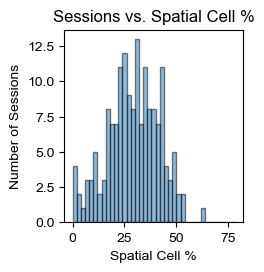

In [28]:
''' Examine spatial cell densities quickly as a sanity check'''

# Assess distribution of spatial/ngs cell densities
print('Mean, SEM spatial Cell %')
print(np.mean(perspatial), stats.sem(perspatial))

#plot spatial cell % distributions
fig, ax = plt.subplots(1,1,figsize = (2.3,2.5), sharey = True)
ax.hist(perspatial, bins = np.arange(0,80,2), edgecolor = 'black',alpha = 0.5, color = 'C0')
ax.set_title('Sessions vs. Spatial Cell %')
ax.set_ylabel('Number of Sessions')
ax.set_xlabel('Spatial Cell %')

plt.show()

In [29]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

print(mice[y_ind], mice[ma_ind], mice[age_ind])
print(len(mice[y_ind]), len(mice[ma_ind]), len(mice[age_ind]))
print(len(y_sind), len(ma_sind), len(age_sind))
Nold = len(mice[age_ind])
Nma = len(mice[ma_ind])
Nyoung = len(mice[y_ind])

['Y20' 'Y21' 'Y22' 'Y23' 'Y24' 'Y25' 'Y26' 'Y27' 'Y28'] ['MA10F' 'MA1F' 'MA2F' 'MA3M' 'MA4M' 'MA5M' 'MA6M' 'MA7M' 'MA8F' 'MA9F'] ['A14' 'A15' 'A16' 'A17' 'A18' 'A19' 'A20' 'A22' 'A23' 'A24']
9 10 10
54 58 55


In [30]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,10)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,9)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in SM_aged_mice:
            idx = np.where(mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in SM_MA_mice:
            idx = np.where(mice == m)[0][0] - Nold
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(mice == m)[0][0] - (Nold + Nma)
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', "",
              'MA10F', 'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F',
              'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# set up handles
from itertools import repeat
per99 = [mperspatial[y_ind], mperspatial[ma_ind], mperspatial[age_ind]]
handles = []

for i in range(len(per99)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        
        if c[0] == col_animal[0][0][8][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.append(l)

# Plot figures verifying classification of spatial cells

Figure 2/S3D, S3F. Not required to run subsequent sections of this notebook.

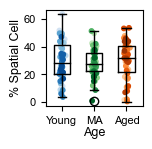


SPATIAL CELL RESULTS:
% young ± SEM; % MA ± SEM; % old ± SEM
29.54 ± 1.87 ; 28.15 ± 1.29 ; 29.85 ± 1.87
F = 1.3196238944413152
p_spatial%session = 0.5169485389611561


In [31]:
'''Spatial Cell Density Young vs. Aged Session by Age Group (Figure 2d) + Stats '''

fig, ax = plt.subplots(figsize = (1.25,1.25))
perspatial = [sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5

plt.boxplot(perspatial, widths = w, labels = labels, medianprops = dict(color = 'black'))
#ax.set_title('Session spatial Cell Density', fontsize=12, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_xticklabels(labels = labels, fontsize=9)
ax.set_ylabel('% Spatial Cell', fontsize=9, labelpad=1)
#ax.set_ylim([0,40])
ax.tick_params(labelsize = 8)

for i in range(len(perspatial)):
    y = perspatial[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], alpha = 1, s = 10)

#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.65, 1))
#plt.savefig(save_folder + 'age_spatialdensity_session.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'age_spatialdensity_session.svg', dpi=400, bbox_inches='tight')
plt.show()

print('\nSPATIAL CELL RESULTS:')
print('% young ± SEM; % MA ± SEM; % old ± SEM')
print(str(np.round(np.mean(sperspatial[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperspatial[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperspatial[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperspatial[y_sind],sperspatial[ma_sind],sperspatial[age_sind])
print('H = ' + str(stat))
print('p_spatial%session = ' + str(p_diff))

In [32]:
''' For spatial cells, save shuffle distributions of sparsity & coherence scores. '''

spatialsparsity = []
spatialshuffsparsity = []
spatialcoherence = []
spatialshuffcoherence = []

P99coherence = []
P99sparsity = []

for m, session in zip(mice, sessions):
    for s in tdqm(session):
        d = data[m][s]
        
        #Load scores, intn boolean to filter out interneurons
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        
        cell_IDs = raw.item().get('cellsfil')
        sparsitya_scores = d['spatialasparsity']
        spatialacoherence_scores = d['spatialacoherencescores']
        shuffsparsityascores = d['shuffsparsityascores'] 
        shuffspatialacoherencescores = d['shuffspatialacoherencescores'] 

        #get cell IDs, filtered behavioral/spike data, & relevant score
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        for i, c in enumerate(cell_IDs):
            sdx = np.where(cell_IDs == c)[0][0]
            
            P99s = np.percentile(np.ravel(shuffsparsityascores[:,sdx]), 99)
            P99c = np.percentile(np.ravel(shuffspatialacoherencescores[:,sdx]), 99)
            P99coherence = np.append(P99coherence, P99c)
            P99sparsity = np.append(P99sparsity, P99s)
        
        for i, c in enumerate(spatialcells):
            sdx = np.where(cell_IDs == c)[0][0]
        
            shuffsparsity = np.random.choice(np.ravel(shuffsparsityascores[:,sdx]))
            shuffcoherence = np.random.choice(np.ravel(shuffspatialacoherencescores[:,sdx]))
            coherence = spatialacoherence_scores[sdx]
            sparsity = sparsitya_scores[sdx]
            
            spatialsparsity = np.append(spatialsparsity,sparsity)
            spatialshuffsparsity = np.append(spatialshuffsparsity,shuffsparsity)
            spatialcoherence = np.append(spatialcoherence,coherence)
            spatialshuffcoherence = np.append(spatialshuffcoherence,shuffcoherence)

print('n total cells: ' + str(len(P99coherence)))
print('n total spatial cells: ' + str(len(spatialsparsity)))
print('mean ± SEM coherence shuffle P99: ' + str(np.nanmean(P99coherence)) + ', ' + str(stats.sem(P99coherence, nan_policy = 'omit')))
print('mean ± SEM sparsity shuffle P99: ' + str(np.nanmean(P99sparsity)) + ', ' + str(stats.sem(P99sparsity, nan_policy = 'omit')))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

n total cells: 43388
n total spatial cells: 12585
mean ± SEM coherence shuffle P99: 0.47053095825735286, 0.000873163996737665
mean ± SEM sparsity shuffle P99: 1.3739416484587894, 0.011832635763318637


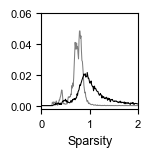

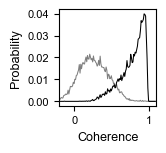


Coherence, Spatial vs. Shuff:
Mean, SEM spatial:
0.7797498712585871 0.0014406273921649738
Mean, SEM Shuffle:
0.25673193772473285 0.0017339289599544276
stat = 705.0
p_cells = 0.0

Sparsity, Spatial vs. Shuff:
Mean, SEM spatial:
1.1775427246385242 0.006503271467083012
Mean, SEM Shuffle:
0.7312761119918176 0.001246514848492602
stat = 16537.0
p_cells = 0.0


In [36]:
''' Plot Coherence & Sparsity Score Distributions vs. Shuffle for spatial Cells (Figure S3f) '''
bins = np.arange(0,2,0.01)
bsparsity, bin_edges = np.histogram(spatialsparsity, bins = bins)
pdf = bsparsity / sum(bsparsity)

shuffbsparsity, shuffbin_edges = np.histogram(spatialshuffsparsity, bins = bins)
shuffpdf = shuffbsparsity / sum(shuffbsparsity)

fig, ax = plt.subplots(figsize = (1.25,1.25))
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
#ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Sparsity', fontsize = 9)
ax.set_xlim([0,2])
#ax.set_ylim([0,0.065])
ax.set_yticks([0,0.02,0.04,0.06])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'spatialsparsity.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'spatialsparsity.svg', dpi=400, bbox_inches='tight')
plt.show()

bins = np.arange(-0.2,1.1,0.01)
bcoherence, bin_edges = np.histogram(spatialcoherence, bins = bins)
pdf = bcoherence / sum(bcoherence)
shuffcoherence, shuffbin_edges = np.histogram(spatialshuffcoherence, bins = bins)
shuffpdf = shuffcoherence / sum(shuffcoherence)

fig, ax = plt.subplots(figsize = (1.25,1.25))
#ax.hist(spatialcoherence, 20, density = True, histtype = 'step', color = 'k')
#ax.hist(spatialshuffsparsity, 20, density = True, histtype = 'step', color = 'k', alpha = 0.5)
ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = 'k')
ax.plot(shuffbin_edges[1:], shuffpdf, linewidth = 0.75, color = 'k', alpha = 0.5)
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Coherence', fontsize = 9)
ax.set_xlim([-0.2,1.1])
#ax.set_ylim([0,0.035])
ax.set_yticks([0,0.01,0.02,0.03,0.04])
ax.tick_params(labelsize = 8)
#plt.savefig(save_folder + 'spatialcoherence.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'spatialcoherence.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
print('\nCoherence, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialcoherence), stats.sem(spatialcoherence, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffcoherence), stats.sem(spatialshuffcoherence, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialcoherence[~np.isnan(spatialshuffcoherence)], spatialshuffcoherence[~np.isnan(spatialshuffcoherence)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

#STATS
print('\nSparsity, Spatial vs. Shuff:')
print('Mean, SEM spatial:')
print(np.nanmean(spatialsparsity), stats.sem(spatialsparsity, nan_policy = 'omit')) 
print('Mean, SEM Shuffle:')
print(np.nanmean(spatialshuffsparsity), stats.sem(spatialshuffsparsity, nan_policy = 'omit')) 
stat, p_diff = stats.wilcoxon(spatialsparsity[~np.isnan(spatialshuffsparsity)], spatialshuffsparsity[~np.isnan(spatialshuffsparsity)])
print('stat = ' + str(stat))
print('p_cells = ' + str(p_diff))

# Spatial Cell Stability, Context-Matched Similarity, & Similarity Ratio

Mimics Figures 2f - k 

In [37]:
''' Compute & Plot Sorted Cross-Trial Correlation Matrices for Spatial Cells; Save Matrices for Later Use 

Run time is a few minutes per session (scales w/ grid cell number).

'''

save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/' # adjust path

for m, session in zip(mice,sessions):

    for s in tdqm(session):
        
        #get data
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        Y = np.load(load_folder + spikes_file, allow_pickle=False) #pre-filtered for speeds >2cm/s, position-corrected spikes, 20 ms timebins
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]    
    
        posx = behaviorfil[:,0]
        trial = behaviorfil[:,2]
        rawtrialfil = raw.item().get('trialfil')
        
        #Find any skipped trials
        try:
            _ = raw.item().get('correctedtrial').shape
            if (len(np.unique(trial)) < 220): 
                alltrial = np.arange(0, np.max(np.unique(trial)) + 1 , 1)
            else:    
                alltrial = np.arange(0,220,1)
            skippedtrials = np.setdiff1d(alltrial, np.unique(trial)).astype(int)
            #print('Skipped trials, n skipped = ' + str(len(skippedtrials)) + str(skippedtrials))
        except: 
            skippedtrials = []
            alltrial = np.arange(0, 220, 1)
        
        if np.max(np.unique(trial)) < 160: #handles truncated, shorter sessions 
            alltrial = np.arange(0, np.max(np.unique(trial)) + 2, 1)
        else:
            alltrial = np.arange(0,220,1)

        # Load in left vs. right info
        trials = np.unique(trial)
        trialinfo = raw.item().get('trialinfo')
        left = trialinfo['left']
        
        #sort trial labels to correspond
        posxcopy = posx.copy()
        leftsort = left.copy()
        alt_idx = 140
        lefttail = left[alt_idx:]
        lefttail = 1 - lefttail
        leftsort[alt_idx:] = lefttail[np.argsort(lefttail, kind = 'stable')]

        #revise skippedtrials locations
        allcopy = alltrial.copy()
        alltail = alltrial[alt_idx:]
        allcopy[alt_idx:] = alltail[np.argsort(lefttail, kind = 'stable')]
        newskippedtrials = []
        for z in skippedtrials:
            newskippedtrials = np.append(newskippedtrials, np.where(allcopy == z)[0][0])

        ndarkskipped = 0
        for z in newskippedtrials:
            if z < 20: 
                ndarkskipped += 1
                
        #sort position & spike train, all copy is in the sorted order
        posxcopy = []
        allcopy = np.append(allcopy, 220)
        for t in allcopy:
            obs_idx = np.where(trial == t)[0]
            posxcopy = np.append(posxcopy, posx[obs_idx])

            if t == 0:
                Z = Y[obs_idx,:]
            else: 
                Z = np.append(Z, Y[obs_idx,:], axis = 0)

        #adjust trialfil so that sorted trials are skipped instead
        count = 0
        if len(skippedtrials) > 0 :
            skippedrawtrialfil = rawtrialfil.copy()
            consec = count_consec(list(np.sort(newskippedtrials).astype(int)))

            for i, k in enumerate(consec):
                t = np.sort(newskippedtrials)[count] 

                if i == 0: 
                    skippedrawtrialfil[rawtrialfil >= t] = skippedrawtrialfil[rawtrialfil >= t] + k
                else: 
                    skippedrawtrialfil[skippedrawtrialfil >= t] = skippedrawtrialfil[skippedrawtrialfil >= t] + k

                count += k
        else:
            skippedrawtrialfil = trial.copy()
        
        #trim off the dark trials & trial 220 dataframes
        start_idx = (np.where(skippedrawtrialfil >= 20)[0][0]).astype(int)
        if np.max(skippedrawtrialfil) == 220:
            end_idx = (np.where(skippedrawtrialfil == 220)[0][0])
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = tuning_curve_bytrial(posxcopy[start_idx:end_idx], skippedrawtrialfil[start_idx:end_idx], Z[start_idx:end_idx,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)
        else:
            end_idx = len(skippedrawtrialfil) + 1
            #get smoothed by trial FR matrix excluding dark period sorted by context
            normFR, _, _ = tuning_curve_bytrial(posxcopy[start_idx:], skippedrawtrialfil[start_idx:], Z[start_idx:,:], dt, sigma = 5, b=2, smooth=True, normalize=True, occupancy=True)

        #collect & plot cross-trial correlation matrices & save for the grid cell population
        allsim = np.zeros(shape = (len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(np.unique(skippedrawtrialfil[start_idx:end_idx])),len(spatialcells)))
        for i, c in enumerate(spatialcells):
            sdx = (np.where(cell_IDs == c)[0][0]).astype(int)  
            sim , _  = ps.cross_trial_correlation(normFR[:,:,sdx], shift = False) 
            allsim[:,:,i] = sim

        # save matrix of cross-trial correlations
        d['allspatialsim'] = allsim
                               
        allspatialsim_file = 'allspatialsim_' + m + '_' + s + '_'+ '.npy'
        np.save(save_folder + allspatialsim_file, allsim)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20 013123_record6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [43]:
''' Calculate Local Cross Trial Correlation Stability within Each Context'''

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

dt = 0.02

#Adjust paths (match load folder to output of cell above)
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/simmatrices/'
sim_load_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/'

slocstab5A = []
slocstab5B = []
slocstab5A_ = []
slocstab5B_ = []

mlocstab5A = []
mlocstab5B = []
mlocstab5A_ = []
mlocstab5B_ = []
max_k = 5

#cell arrays
ylocstab5A = []
ylocstab5B = []
ylocstab5A_ = []
ylocstab5B_ = []

malocstab5A = []
malocstab5B = []
malocstab5A_ = []
malocstab5B_ = []

alocstab5A = []
alocstab5B = []
alocstab5A_ = []
alocstab5B_ = []

blockstability = []

for m, session in zip(mice, sessions):
    
    m_locstab5A = []
    m_locstab5B = []
    m_locstab5A_ = []
    m_locstab5B_ = []
    
    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]   
        
        trial = behaviorfil[:,2]
        
        #load the context lengths, exclude A' and B' gain change trials
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx']
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        allspatialsim_file = 'allspatialsim_' + m + '_' + s + '_'+ '.npy'
        d['allspatialsim'] = np.load(sim_load_folder + allspatialsim_file)
        allspatialsim = d['allspatialsim']
        
        local_stabilityA = []
        local_stabilityB = []
        local_stabilityA_ = []
        local_stabilityB_ = []
        for i, c in enumerate(spatialcells):
            
            #divide sim by context
            sim = allspatialsim[:,:,i]
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:(lengthA + lengthB),lengthA:(lengthA + lengthB)]
            simA_ = sim[(lengthA + lengthB):(lengthA + lengthB + lengthA_), (lengthA + lengthB):(lengthA + lengthB + lengthA_)]
            simB_ = sim[(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_),(lengthA + lengthB + lengtha_):(lengthA + lengthB + lengtha_ + lengthB_)]
            
            # Context A local neighborhood 5 trials
            max_k = 5
            sum_k = np.zeros(simA.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA, offset=k)
            local_stabilityA = np.append(local_stabilityA, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 1

            #Context B
            max_k = 5
            sum_k = np.zeros(simB.shape[0])
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB, offset=k)
            local_stabilityB = np.append(local_stabilityB, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 2

            #Context A_
            max_k = 5
            sum_k = np.zeros(simA_.shape[0])
            
            if simA_.shape[0] <= 2*max_k:
                print(m, s, simA_.shape[0], simB_.shape[0])
                max_k = simA_.shape[0]//2
                max_k = 3
                
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simA_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simA_, offset=k)
                    
            local_stabilityA_ = np.append(local_stabilityA_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
            
            #Context B_
            if simB_.shape[0] <= 10:
                print('keeping lower max k for B_...' + str(max_k))
            else: 
                max_k = 5
                
            sum_k = np.zeros(simB_.shape[0])
            
            for k in np.arange(-max_k, max_k+1, 1):
                if k == 0:
                    continue
                elif k < 0:
                    sum_k[np.abs(k):] = sum_k[np.abs(k):] + np.diagonal(simB_, offset=k)
                else:
                    sum_k[:-k] = sum_k[:-k] + np.diagonal(simB_, offset=k)
                    
            local_stabilityB_ = np.append(local_stabilityB_, np.nanmean(sum_k[max_k:-max_k]/(2*max_k)))
            blockstability = np.append(blockstability, np.nanmean(sum_k[max_k:-max_k]/(2*max_k))) # block 3
        
        #save session results
        slocstab5A = np.append(slocstab5A, np.nanmean(local_stabilityA))
        m_locstab5A = np.append(m_locstab5A, local_stabilityA)
        slocstab5B = np.append(slocstab5B, np.nanmean(local_stabilityB))
        m_locstab5B = np.append(m_locstab5B, local_stabilityB)
        slocstab5A_ = np.append(slocstab5A_, np.nanmean(local_stabilityA_))
        m_locstab5A_ = np.append(m_locstab5A_, local_stabilityA_)    
        slocstab5B_ = np.append(slocstab5B_, np.nanmean(local_stabilityB_))
        m_locstab5B_ = np.append(m_locstab5B_, local_stabilityB_)
        
        #pool by age group
        if m in SM_aged_mice:
            alocstab5A = np.append(alocstab5A, local_stabilityA) 
            alocstab5B = np.append(alocstab5B, local_stabilityB) 
            alocstab5A_ = np.append(alocstab5A_, local_stabilityA_) 
            alocstab5B_ = np.append(alocstab5B_, local_stabilityB_) 
        elif m in SM_MA_mice:
            malocstab5A = np.append(malocstab5A, local_stabilityA) 
            malocstab5B = np.append(malocstab5B, local_stabilityB) 
            malocstab5A_ = np.append(malocstab5A_, local_stabilityA_) 
            malocstab5B_ = np.append(malocstab5B_, local_stabilityB_) 
        else:
            ylocstab5A = np.append(ylocstab5A, local_stabilityA) 
            ylocstab5B = np.append(ylocstab5B, local_stabilityB) 
            ylocstab5A_ = np.append(ylocstab5A_, local_stabilityA_) 
            ylocstab5B_ = np.append(ylocstab5B_, local_stabilityB_) 
            
    #pool by animal
    mlocstab5A = np.append(mlocstab5A, np.nanmean(m_locstab5A))
    mlocstab5B = np.append(mlocstab5B, np.nanmean(m_locstab5B))
    mlocstab5A_ = np.append(mlocstab5A_, np.nanmean(m_locstab5A_))
    mlocstab5B_ = np.append(mlocstab5B_, np.nanmean(m_locstab5B_))

#save arrays
slocstab5A = np.asarray(slocstab5A)
slocstab5B = np.asarray(slocstab5B)
slocstab5A_ = np.asarray(slocstab5A_)
slocstab5B_ = np.asarray(slocstab5B_)

mlocstab5A = np.asarray(mlocstab5A)
mlocstab5B = np.asarray(mlocstab5B)
mlocstab5A_ = np.asarray(mlocstab5A_)
mlocstab5B_ = np.asarray(mlocstab5B_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123_record6 7 10
keeping lower max k for B_...3
A20 013123

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each Spatial Cell'''
import statsmodels.api as sm
import statsmodels.formula.api as smf

engagement_folder = 'C:/Users/Python/Desktop/LocalData/behaviorsm/engagement' #adjust path

sex = list(animalmeta.Sex[mice_ind])
csex = []
cmice = []
ccount = []
cage = []
cidx = []
ccohort = []
cengageA = []
cengageB = []
cengageA_ = []
cengageB_ = []

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = sex[np.where(mice == m)[0][0]]
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    cohort =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Cohort'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]
        
        engagement_file = 'engagement_' + str(m) + '_' + str(s) + '.npy'
        blocknclickrate = np.load(engagement_folder + engagement_file)
        
        for j, c in enumerate(spatialcells):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            ccohort = np.append(ccohort, cohort)
            cengageA = np.append(cengageA, blocknclickrate[0])
            cengageB = np.append(cengageA, blocknclickrate[1])
            cengageA_ = np.append(cengageA, blocknclickrate[2])
            cengageB_ = np.append(cengageA, blocknclickrate[3])
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Cohort = list(ccohort)
EngageA = list(cengageA)
EngageB = list(cengageB)
EngageA_ = list(cengageA_)
EngageB_ = list(cengageB_)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5A
No. Observations:     12585       Method:                 REML     
No. Groups:           29          Scale:                  0.0165   
Min. group size:      95          Log-Likelihood:         2046.7870
Max. group size:      770         Converged:              Yes      
Mean group size:      434.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.366    0.028 13.005 0.000  0.311  0.421
C(AgeGroup)[T.2.0]       -0.105    0.042 -2.531 0.011 -0.187 -0.024
C(AgeGroup)[T.3.0]        0.031    0.033  0.942 0.346 -0.034  0.096
C(Sex)[T.M]               0.031    0.043  0.716 0.474 -0.054  0.116
C(Cohort)[T.D]           -0.030    0.054 -0.554 0.579 -0.135  0

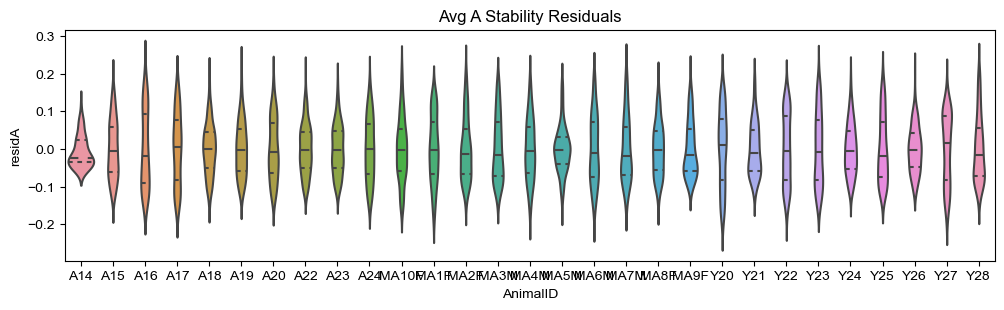

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     locstab5B
No. Observations:     12585       Method:                 REML     
No. Groups:           29          Scale:                  0.0162   
Min. group size:      95          Log-Likelihood:         2302.8914
Max. group size:      770         Converged:              Yes      
Mean group size:      434.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.312    0.030 10.515 0.000  0.254  0.371
C(AgeGroup)[T.2.0]       -0.054    0.044 -1.215 0.225 -0.140  0.033
C(AgeGroup)[T.3.0]        0.007    0.035  0.204 0.839 -0.061  0.076
C(Sex)[T.M]               0.017    0.046  0.372 0.710 -0.073  0.108
C(Cohort)[T.D]            0.004    0.057  0.066 0.947 -0.108  0

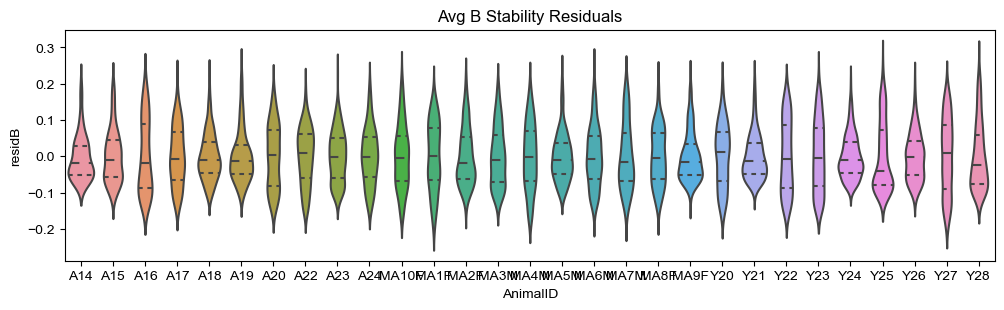

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5A_
No. Observations:      12585      Method:                REML      
No. Groups:            29         Scale:                 0.0104    
Min. group size:       95         Log-Likelihood:        5215.0631 
Max. group size:       770        Converged:             Yes       
Mean group size:       434.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.146    0.026  5.631 0.000  0.095  0.196
C(AgeGroup)[T.2.0]       -0.076    0.039 -1.976 0.048 -0.152 -0.001
C(AgeGroup)[T.3.0]        0.067    0.030  2.198 0.028  0.007  0.127
C(Sex)[T.M]               0.036    0.040  0.878 0.380 -0.044  0.115
C(Cohort)[T.D]           -0.029    0.050 -0.578 0.563 -0.127  0

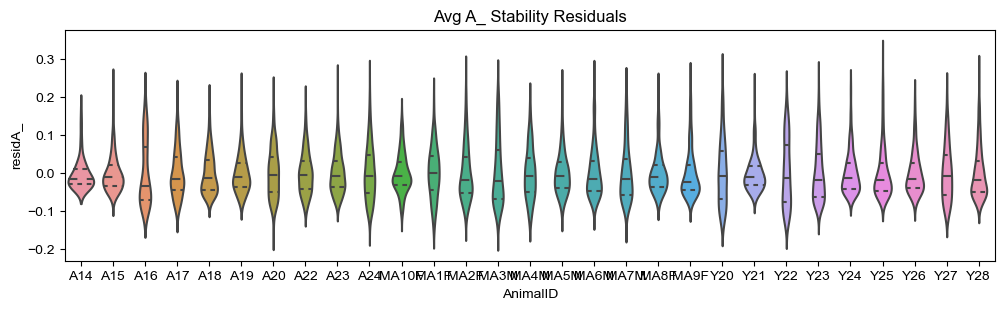

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    locstab5B_
No. Observations:      12585      Method:                REML      
No. Groups:            29         Scale:                 0.0099    
Min. group size:       95         Log-Likelihood:        5462.2663 
Max. group size:       770        Converged:             Yes       
Mean group size:       434.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.123    0.024  5.120 0.000  0.076  0.171
C(AgeGroup)[T.2.0]       -0.047    0.036 -1.304 0.192 -0.117  0.024
C(AgeGroup)[T.3.0]        0.060    0.028  2.105 0.035  0.004  0.115
C(Sex)[T.M]               0.047    0.038  1.246 0.213 -0.027  0.120
C(Cohort)[T.D]           -0.025    0.046 -0.541 0.589 -0.116  0

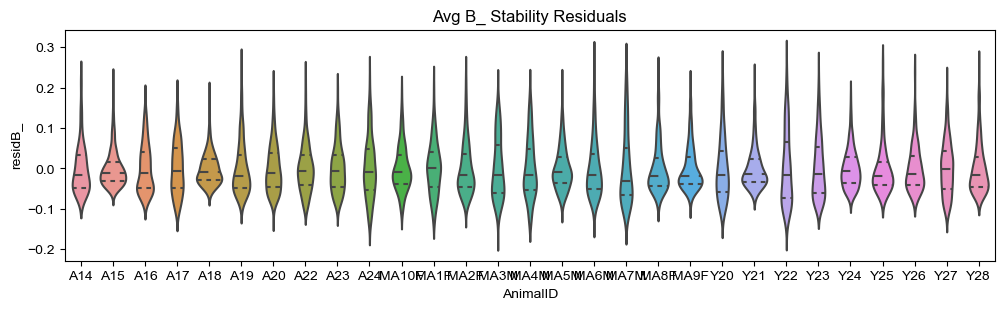

In [45]:
''' LMMs for Moving Avg Similarity [Stability] '''        
#gather dependent variables into lists
locstab5A = list(np.concatenate((alocstab5A, malocstab5A, ylocstab5A)))
locstab5B = list(np.concatenate((alocstab5B, malocstab5B, ylocstab5B)))
locstab5A_ = list(np.concatenate((alocstab5A_, malocstab5A_, ylocstab5A_)))
locstab5B_ = list(np.concatenate((alocstab5B_, malocstab5B_, ylocstab5B_)))
hue_order = [1.0, 3.0, 2.0]

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, locstab5A, locstab5B, locstab5A_, locstab5B_))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','locstab5A','locstab5B', 'locstab5A_', 'locstab5B_'])

#handle NaNs
df = df.dropna(axis = 0)

#AA Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('locstab5A ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['residA'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA', inner = 'quartile', ax = ax)
plt.title('Avg A Stability Residuals')
plt.show()

#BB Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('locstab5B ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['residB'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB', inner = 'quartile', ax = ax)
plt.title('Avg B Stability Residuals')
plt.show()

#A_A_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('locstab5A_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['residA_'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residA_', inner = 'quartile', ax = ax)
plt.title('Avg A_ Stability Residuals')
plt.show()

#B_B_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('locstab5B_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['residB_'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'residB_', inner = 'quartile', ax = ax)
plt.title('Avg B_ Stability Residuals')
plt.show()


In [46]:
''' Get fitted session averages '''

r = 6 #sessions

df['mA_fitted'] = mA_.fittedvalues
df['mB_fitted'] = mB_.fittedvalues

resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mA_fitted'].aggregate('mean')
#print(resultA_)
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mA_fitted'])

resultB_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mB_fitted'].aggregate('mean')
seshBanimal = np.asarray(resultB_['AnimalID'])
seshBcount = np.asarray(resultB_['Session'])
seshB_mean = np.asarray(resultB_['mB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]
slocstab5B_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5B_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5B_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]
sessionBcount_fitted_aged = [[] * r for i in range(r)]
sessionBcount_fitted_MA = [[] * r for i in range(r)]
sessionBcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5B_fitted_seg_aged[idx] = np.append(slocstab5B_fitted_seg_aged[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_aged[idx] = np.append(sessionBcount_fitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_MA[idx] = np.append(slocstab5B_fitted_seg_MA[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_MA[idx] = np.append(sessionBcount_fitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_young[idx] = np.append(slocstab5B_fitted_seg_young[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_young[idx] = np.append(sessionBcount_fitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for A`
10 10 9

n aged, MA, young mice on day 1 for B`
10 10 9

n aged, MA, young mice on day 2 for A`
10 10 9

n aged, MA, young mice on day 2 for B`
10 10 9

n aged, MA, young mice on day 3 for A`
10 10 9

n aged, MA, young mice on day 3 for B`
10 10 9

n aged, MA, young mice on day 4 for A`
9 10 9

n aged, MA, young mice on day 4 for B`
9 10 9

n aged, MA, young mice on day 5 for A`
8 9 9

n aged, MA, young mice on day 5 for B`
8 9 9

n aged, MA, young mice on day 6 for A`
8 9 9

n aged, MA, young mice on day 6 for B`
8 9 9


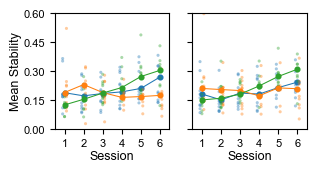

In [51]:
''' Composite Plot of Alternation Stability w/ Fitted Session Average Data Points (Figure 2f)'''
f, ax = plt.subplots(1, 2, figsize=(3.25, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mA_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[0].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[0].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
ax[0].set_ylim([0.0,0.6])
ax[0].tick_params(labelsize = 8)
ax[0].set_ylabel('Mean Stability', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[1].set_yticks([0,0.15,0.3,0.45,0.6])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
#ax[1].set_ylabel('Stability', fontsize=9, labelpad=1)
g1.legend_.remove()

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for A`')
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for B`')
    print(len(sessionBcount_fitted_aged[i]),len(sessionBcount_fitted_MA[i]), len(sessionBcount_fitted_young[i]))
    
    ax[0].scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcount_fitted_aged[i] + 0.1, slocstab5B_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_MA[i], slocstab5B_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_young[i] - 0.1, slocstab5B_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

#ax[0].legend(loc = 4, fontsize = 9)
#plt.savefig(save_folder + 'time_altstabilityfitted_composite_LMM.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_altstabilityfitted_composite_LMM.svg', dpi=400, bbox_inches='tight')
plt.show()

In [56]:
''' Find where I will have NaNs'''
nan_idxspatial = np.where((sperspatial == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindspatial = np.setdiff1d(y_sind, nan_idxspatial)
ma_sindspatial = np.setdiff1d(ma_sind, nan_idxspatial)
age_sindspatial = np.setdiff1d(age_sind, nan_idxspatial)

col_sessionspatial = [col_session_young, col_session_MA, col_session_old] 

# This will fix session stats & box plots are plotted.

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.23356112467755066 0.6777100527517484 0.4022833792292584 0.4401938808820359
P [Young, MA, Aged, All]: 
0.08917708604665675 5.121826411936326e-09 0.0023295160755173222 2.6394085601078282e-09
0.8623408705687187 0.8791666666666667 0.45789859456440807

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.23414248432004553 0.8571685256373264 0.7289984404006846 0.6695313807496241
P [Young, MA, Aged, All]: 
0.5442663916419431 0.003144270376022072 0.040192078729224 0.00018346476071076404


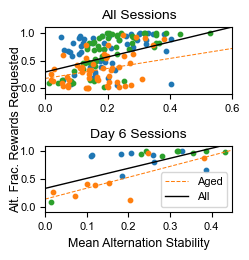

In [57]:
''' Plot Figure 2g '''
### TOTAL ALT STABILITY vs. REQ RATES
slocstab5alt = np.nanmean(np.vstack((slocstab5A_,slocstab5B_)), axis = 0)

#Linear regression
res = stats.linregress(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(slocstab5alt[~np.isnan(slocstab5alt)],reqalt_rates[~np.isnan(slocstab5alt)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
        
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)
ax[0].scatter(slocstab5alt[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', s = 10)
ax[0].scatter(slocstab5alt[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', s = 10)
ax[0].scatter(slocstab5alt[age_sindspatial],reqalt_rates[age_sindspatial], color = 'C1', s = 10)
ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0,0.6])
ax[0].set_yticks([0,0.5,1.0])
ax[0].tick_params(labelsize = 8)
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')
#ax.legend(loc = 4, fontsize = 9, prop = {'size': 10})
#plt.savefig(save_folder + 'alldays_stab_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_stab_correlation.svg', dpi = 400, bbox_inches = 'tight')

#Select 6th sessions
sixthsesh = []
seshcount = 0
for m, session in zip(mice, sessions):
    totalsesh = len(session)
    for i, s in enumerate(session):
        if (i == (totalsesh - 1)) & (totalsesh >= 6):
            sixthsesh = np.append(sixthsesh, seshcount)
        seshcount += 1

# Get indices for six sesssions in each age group
y_sind6th = np.intersect1d(y_sindspatial, sixthsesh).astype(int)
ma_sind6th = np.intersect1d(ma_sindspatial, sixthsesh).astype(int)
age_sind6th = np.intersect1d(age_sindspatial, sixthsesh).astype(int)
print(np.mean(reqalt_rates[y_sind6th]), np.mean(reqalt_rates[ma_sind6th]), np.mean(reqalt_rates[age_sind6th]))

### TOTAL ALT STABILITY vs. 6th day REQ RATES
slocstab5alt = np.nanmean(np.vstack((slocstab5A_,slocstab5B_)), axis = 0)

#Linear regression
res = stats.linregress(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th,ma_sind6th,age_sind6th))
res = stats.linregress(slocstab5alt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

# Plot Day 6 relationships
ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(slocstab5alt[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 10)
ax[1].scatter(slocstab5alt[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 10)
ax[1].scatter(slocstab5alt[age_sind6th],reqalt_rates[age_sind6th], color = 'C1', s = 10)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0,0.45])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All')
ax[1].set_xlabel('Mean Alternation Stability', fontsize = 9)
ax[1].legend(loc = 4, fontsize = 8, prop = {'size': 8})

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + 'day6_stab_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'day6_stab_correlation.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [82]:
''' Calculate Spatial Avg Similarity within Each Context & on Off Diagonal'''
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/'
save_folder = 'C:/Users/Python/Desktop/LocalData/spatialcellssm/crosstrial/sorted/spatial/'

dt = 0.02

sstabABdiag = []
sstabBA_diag = []
sstabAB_diag = []
sstabAA_diag = []
sstabBB_diag = []

ystabABdiag = []
ystabBA_diag = []
ystabAB_diag = []
ystabAA_diag = []
ystabBB_diag = []

mastabABdiag = []
mastabBA_diag = []
mastabAB_diag = []
mastabAA_diag = []
mastabBB_diag = []

astabABdiag = []
astabBA_diag = []
astabAB_diag = []
astabAA_diag = []
astabBB_diag = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell = d['spatialcell99'].astype(bool)
        spatialcells = cell_IDs[spatialcell]     
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allspatialsim = d['allspatialsim']

        ABdiag = []
        AB_diag = []
        AA_diag = []
        BA_diag = []
        BB_diag = []
        
        for i, c in enumerate(spatialcells):
            sim = allspatialsim[:,:,i]
            #sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))

            #divide sim by context
            simA = sim[:lengthA,:lengthA]
            simB = sim[lengthA:nB,lengthA:nB]
            simA_ = sim[nB:nA_,nB:nA_]
            simB_ = sim[na_:nB_,na_:nB_]
            
            # Context A spatial stability
            baseline_sim = pd.DataFrame(simA) #non-gain vs. non-gain
            baselineAstab = ((baseline_sim.sum().sum() - lengthA) / 2) / ((lengthA**2 - lengthA)/2)

            #Context B
            baseline_sim = pd.DataFrame(simB) #non-gain vs. non-gain
            baselineBstab = ((baseline_sim.sum().sum() - lengthB) / 2) / ((lengthB**2 - lengthB)/2)
            
            #Baseline Subtracted Off diagonal avg. pairwise correlation as a percentage of baseline stability
            if baselineAstab >= 0.1:
                ABdiag = np.append(ABdiag, sim[lengthA:nB, :lengthA].mean())
                AB_diag = np.append(AB_diag, sim[na_:nB_,:lengthA].mean())
                AA_diag = np.append(AA_diag, sim[nB:nA_,:lengthA].mean())
            else:
                ABdiag = np.append(ABdiag, np.nan)
                AB_diag = np.append(AB_diag, np.nan)
                AA_diag = np.append(AA_diag, np.nan)
                
            if baselineBstab >= 0.1:
                BA_diag = np.append(BA_diag, sim[nB:nA_,lengthA:nB].mean())
                BB_diag = np.append(BB_diag, sim[na_:nB_,lengthA:nB].mean())
            else:
                BA_diag = np.append(BA_diag, np.nan)
                BB_diag = np.append(BB_diag, np.nan)
                
        #Off diagonal avg. pairwise correlation
        sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
        sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
        sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A
        sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
        sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B
        
        #pool age group results
        if m in SM_aged_mice:
            astabABdiag = np.append(astabABdiag, ABdiag)
            astabBA_diag = np.append(astabBA_diag, BA_diag)
            astabAB_diag = np.append(astabAB_diag, AB_diag)
            astabAA_diag = np.append(astabAA_diag, AA_diag)
            astabBB_diag = np.append(astabBB_diag, BB_diag)
        elif m in SM_MA_mice:
            mastabABdiag = np.append(mastabABdiag, ABdiag)
            mastabBA_diag = np.append(mastabBA_diag, BA_diag)
            mastabAB_diag = np.append(mastabAB_diag, AB_diag)
            mastabAA_diag = np.append(mastabAA_diag, AA_diag)
            mastabBB_diag = np.append(mastabBB_diag, BB_diag)
        else:
            ystabABdiag = np.append(ystabABdiag, ABdiag)
            ystabBA_diag = np.append(ystabBA_diag, BA_diag)
            ystabAB_diag = np.append(ystabAB_diag, AB_diag)
            ystabAA_diag = np.append(ystabAA_diag, AA_diag)
            ystabBB_diag = np.append(ystabBB_diag, BB_diag)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:106: RuntimeWarning: Mean of empty slice
  sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:107: RuntimeWarning: Mean of empty slice
  sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:108: RuntimeWarning: Mean of empty slice
  sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:109: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:110: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:109: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:110: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:109: RuntimeWarning: Mean of empty slice
  sstabBA_diag = np.append(sstabBA_diag, np.nanmean(BA_diag)) #A' x B
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:110: RuntimeWarning: Mean of empty slice
  sstabBB_diag = np.append(sstabBB_diag, np.nanmean(BB_diag)) #B' x B


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:106: RuntimeWarning: Mean of empty slice
  sstabABdiag = np.append(sstabABdiag, np.nanmean(ABdiag)) #B x A
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:107: RuntimeWarning: Mean of empty slice
  sstabAB_diag = np.append(sstabAB_diag, np.nanmean(AB_diag)) #B' x A
C:\Users\Python\AppData\Local\Temp\ipykernel_12992\470292661.py:108: RuntimeWarning: Mean of empty slice
  sstabAA_diag = np.append(sstabAA_diag, np.nanmean(AA_diag)) #A' x A


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     stabABdiag
No. Observations:      8926        Method:                 REML      
No. Groups:            29          Scale:                  0.0108    
Min. group size:       34          Log-Likelihood:         3189.6926 
Max. group size:       562         Converged:              Yes       
Mean group size:       307.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.176    0.021  8.314 0.000  0.134  0.217
C(AgeGroup)[T.2.0]         -0.057    0.031 -1.860 0.063 -0.118  0.003
C(AgeGroup)[T.3.0]         -0.047    0.025 -1.863 0.062 -0.095  0.002
C(Sex)[T.M]                 0.039    0.031  1.233 0.217 -0.023  0.100
C(Cohort)[T.D]             -0.065   

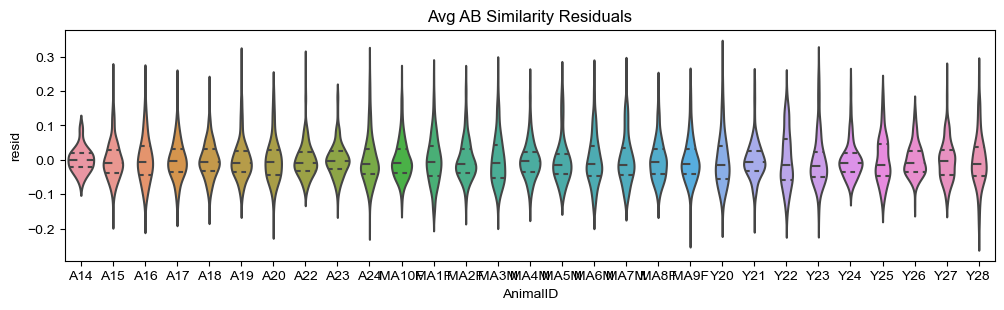

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     stabAA_  
No. Observations:     8926        Method:                 REML     
No. Groups:           29          Scale:                  0.0096   
Min. group size:      34          Log-Likelihood:         4053.2564
Max. group size:      562         Converged:              Yes      
Mean group size:      307.8                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.123    0.025  4.903 0.000  0.074  0.172
C(AgeGroup)[T.2.0]       -0.025    0.037 -0.665 0.506 -0.098  0.048
C(AgeGroup)[T.3.0]        0.029    0.030  0.969 0.332 -0.029  0.087
C(Sex)[T.M]               0.020    0.039  0.530 0.596 -0.055  0.096
C(Cohort)[T.D]           -0.045    0.048 -0.944 0.345 -0.139  0

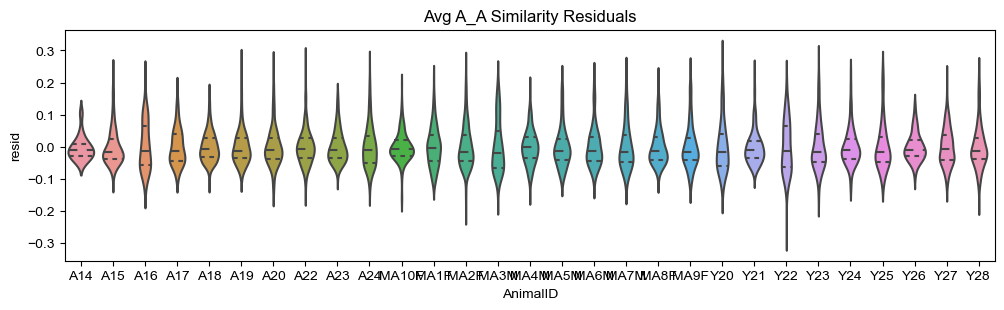

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     stabBB_  
No. Observations:     8926        Method:                 REML     
No. Groups:           29          Scale:                  0.0086   
Min. group size:      34          Log-Likelihood:         4272.2124
Max. group size:      562         Converged:              Yes      
Mean group size:      307.8                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.155    0.020  7.802 0.000  0.116  0.195
C(AgeGroup)[T.2.0]       -0.022    0.029 -0.742 0.458 -0.079  0.035
C(AgeGroup)[T.3.0]        0.029    0.024  1.236 0.217 -0.017  0.075
C(Sex)[T.M]               0.021    0.030  0.688 0.491 -0.038  0.079
C(Cohort)[T.D]           -0.030    0.037 -0.813 0.416 -0.103  0

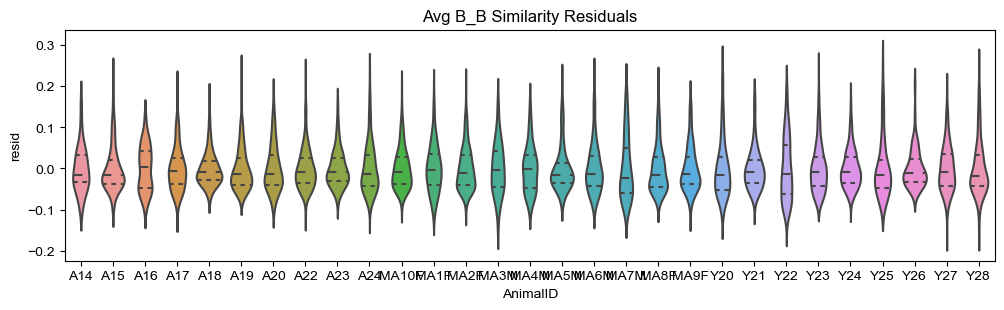

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     stabAB_  
No. Observations:       8926        Method:                 REML     
No. Groups:             29          Scale:                  0.0056   
Min. group size:        34          Log-Likelihood:         5006.6521
Max. group size:        562         Converged:              Yes      
Mean group size:        307.8                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.101    0.016  6.108 0.000  0.068  0.133
C(AgeGroup)[T.2.0]         -0.040    0.024 -1.658 0.097 -0.086  0.007
C(AgeGroup)[T.3.0]          0.001    0.019  0.032 0.975 -0.037  0.039
C(Sex)[T.M]                 0.035    0.024  1.437 0.151 -0.013  0.082
C(Cohort)[T.D]             -0.047   

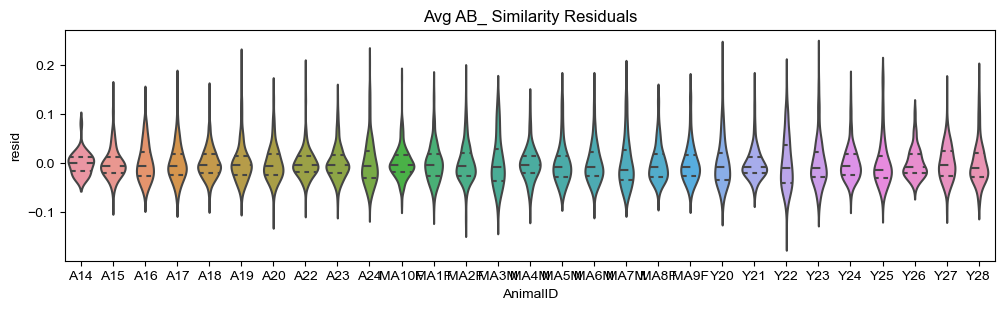

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     stabBA_  
No. Observations:       8926        Method:                 REML     
No. Groups:             29          Scale:                  0.0077   
Min. group size:        34          Log-Likelihood:         4611.3731
Max. group size:        562         Converged:              Yes      
Mean group size:        307.8                                        
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.134    0.016  8.260 0.000  0.102  0.166
C(AgeGroup)[T.2.0]         -0.034    0.023 -1.460 0.144 -0.080  0.012
C(AgeGroup)[T.3.0]         -0.002    0.019 -0.088 0.930 -0.039  0.036
C(Sex)[T.M]                 0.025    0.023  1.079 0.281 -0.021  0.071
C(Cohort)[T.D]             -0.043   

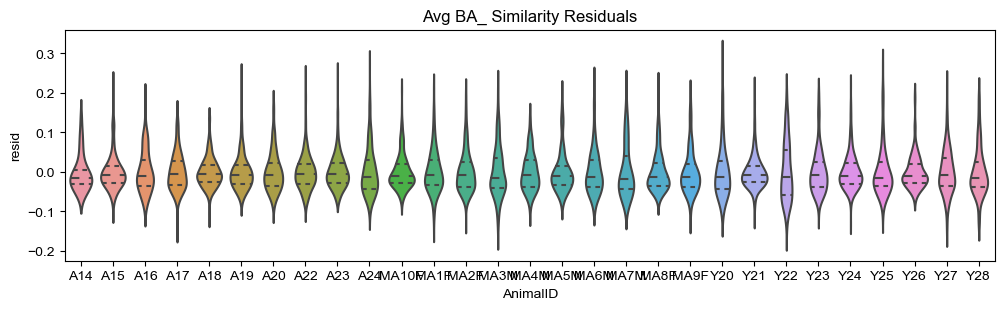

In [83]:
''' LMMs for Avg Similarity On Diag '''   
hue_order = [1.0,3.0,2.0]
#gather dependent variables into lists
stabABdiag = list(np.concatenate((astabABdiag, mastabABdiag, ystabABdiag)))
stabAA_diag = list(np.concatenate((astabAA_diag, mastabAA_diag, ystabAA_diag)))
stabBB_diag = list(np.concatenate((astabBB_diag, mastabBB_diag, ystabBB_diag)))
stabAB_diag = list(np.concatenate((astabAB_diag, mastabAB_diag, ystabAB_diag)))
stabBA_diag = list(np.concatenate((astabBA_diag, mastabBA_diag, ystabBA_diag)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, stabABdiag, stabAA_diag, stabBB_diag,stabAB_diag,stabBA_diag))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','stabABdiag','stabAA_', 'stabBB_','stabAB_','stabBA_'])

#handle NaNs
df = df.dropna(axis = 0)

# AB Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('stabABdiag ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg AB Similarity Residuals')
plt.show()

# A_A Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA = smf.mixedlm('stabAA_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA.summary())
print(mA.wald_test_terms(scalar = False))

df['resid'] = mA.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg A_A Similarity Residuals')
plt.show()

# B_B Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB = smf.mixedlm('stabBB_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB.summary())
print(mB.wald_test_terms(scalar = False))

df['resid'] = mB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg B_B Similarity Residuals')
plt.show()

# AB_Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_ = smf.mixedlm('stabAB_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageB_ + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_.summary())
print(mA_.wald_test_terms(scalar = False))

df['resid'] = mA_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg AB_ Similarity Residuals')
plt.show()

# BA_ Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mB_ = smf.mixedlm('stabBA_ ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + EngageA_ + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mB_.summary())
print(mB_.wald_test_terms(scalar = False))

df['resid'] = mB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Avg BA_ Similarity Residuals')
plt.show()

In [84]:
''' Get fitted session averages '''

df['mAfitted'] = mA.fittedvalues
df['mBfitted'] = mB.fittedvalues

resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAfitted'].aggregate('mean')
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAfitted'])

resultB_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mBfitted'].aggregate('mean')
seshBanimal = np.asarray(resultB_['AnimalID'])
seshBcount = np.asarray(resultB_['Session'])
seshB_mean = np.asarray(resultB_['mBfitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]
slocstab5B_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5B_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5B_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]
sessionBcount_fitted_aged = [[] * r for i in range(r)]
sessionBcount_fitted_MA = [[] * r for i in range(r)]
sessionBcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    sessionb_idx = np.where(seshBanimal == m)[0]

    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1 
            slocstab5B_fitted_seg_aged[idx] = np.append(slocstab5B_fitted_seg_aged[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_aged[idx] = np.append(sessionBcount_fitted_aged[idx], c - 1)    
        
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_MA[idx] = np.append(slocstab5B_fitted_seg_MA[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_MA[idx] = np.append(sessionBcount_fitted_MA[idx], c - 1)   
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            
        for i, c in enumerate(seshBcount[sessionb_idx]):
            idx = c.astype(int) - 1
            slocstab5B_fitted_seg_young[idx] = np.append(slocstab5B_fitted_seg_young[idx],seshB_mean[sessionb_idx][i])
            sessionBcount_fitted_young[idx] = np.append(sessionBcount_fitted_young[idx], c - 1)   


n aged, MA, young mice on day 1 for AxA`
9 10 8

n aged, MA, young mice on day 1 for BxB`
9 10 8

n aged, MA, young mice on day 2 for AxA`
9 10 9

n aged, MA, young mice on day 2 for BxB`
9 10 9

n aged, MA, young mice on day 3 for AxA`
10 10 9

n aged, MA, young mice on day 3 for BxB`
10 10 9

n aged, MA, young mice on day 4 for AxA`
9 10 9

n aged, MA, young mice on day 4 for BxB`
9 10 9

n aged, MA, young mice on day 5 for AxA`
8 9 9

n aged, MA, young mice on day 5 for BxB`
8 9 9

n aged, MA, young mice on day 6 for AxA`
8 8 9

n aged, MA, young mice on day 6 for BxB`
8 8 9


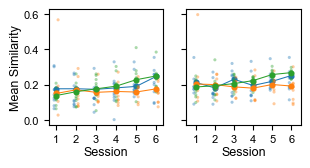

In [85]:
''' Plot Figure 2h '''
f, ax = plt.subplots(1, 2, figsize=(3.25, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mA.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[0], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[0].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
ax[0].set_ylabel('Mean Similarity', fontsize=9, labelpad=1)
ax[0].set_xlabel('Session', fontsize=9, labelpad=1)
ax[0].tick_params(labelsize = 8)
g.legend_.remove()

g1 = sns.pointplot(x = df['Session'], y = mB.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax[1], scale = 0.5)
ax[1].set_xticks([0,1,2,3,4,5])
ax[1].set_xticklabels([1,2,3,4,5,6])
ax[1].set_xlim([-0.5,5.5])
#ax[1].set_ylim([0,0.45])
ax[1].set_xlabel('Session', fontsize=9, labelpad=1)
ax[1].tick_params(labelsize = 8)
g1.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for AxA`')
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    print('\nn aged, MA, young mice on day ' + str(i + 1) + ' for BxB`')
    print(len(sessionBcount_fitted_aged[i]),len(sessionBcount_fitted_MA[i]), len(sessionBcount_fitted_young[i]))
    
    ax[0].scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[0].scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')
    
    ax[1].scatter(sessionBcount_fitted_aged[i] + 0.1, slocstab5B_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_MA[i], slocstab5B_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax[1].scatter(sessionBcount_fitted_young[i] - 0.1, slocstab5B_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)
    
for l in g1.lines:
    plt.setp(l,linewidth = 0.75)
    
#ax[0].legend(loc = 4, fontsize = 9)
#plt.savefig(save_folder + 'time_recognition_fitted_composite_LMM.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_recognition_fitted_composite_LMM.svg', dpi=400, bbox_inches='tight')
plt.show()

C:\Users\Python\AppData\Local\Temp\ipykernel_12992\2604473103.py:3: RuntimeWarning: Mean of empty slice
  sstabalt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)


Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.2917730406093232 0.6600337296776947 0.28032458619723594 0.378631339413135
P [Young, MA, Aged, All]: 
0.03229524227467799 1.7401679857555918e-08 0.04006080855627518 4.904486129606462e-07

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
-0.1033608282503027 0.8862934654002731 0.754644580892076 0.6499485341889366
P [Young, MA, Aged, All]: 
0.7913006841390542 0.001458050154137141 0.03046407086603943 0.0003259084860817333


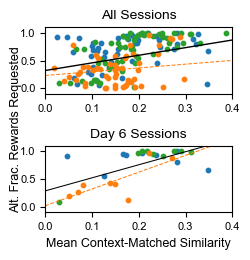

In [86]:
''' Plot Figure 2i '''
### TOTAL ALT vs. REQ RATES
sstabalt = np.nanmean(np.vstack((sstabAA_diag,sstabBB_diag)), axis = 0)

#Linear regression
res = stats.linregress(sstabalt[y_sindspatial],reqalt_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sstabalt[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sstabalt[age_sindspatial][~np.isnan(sstabalt[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sstabalt[age_sindspatial])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sstabalt[~np.isnan(sstabalt)],reqalt_rates[~np.isnan(sstabalt)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
    
#plot top half    
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)
ax[0].scatter(sstabalt[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', s = 10)
ax[0].scatter(sstabalt[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', s = 10)
ax[0].scatter(sstabalt[age_sindspatial][~np.isnan(sstabalt[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sstabalt[age_sindspatial])], color = 'C1', s = 10)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_yticks([0,0.5,1.0])
ax[0].set_xlim([0,0.4])
ax[0].tick_params(labelsize = 8)
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#Gather 6th session data
#Linear regression
res = stats.linregress(sstabalt[y_sind6th][~np.isnan(sstabalt[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sstabalt[y_sind6th])])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sstabalt[ma_sind6th][~np.isnan(sstabalt[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sstabalt[ma_sind6th])])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sstabalt[age_sind6th][~np.isnan(sstabalt[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sstabalt[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th[~np.isnan(sstabalt[y_sind6th])],ma_sind6th[~np.isnan(sstabalt[ma_sind6th])],age_sind6th[~np.isnan(sstabalt[age_sind6th])]))
res = stats.linregress(sstabalt[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sstabalt[y_sind6th],reqalt_rates[y_sind6th], color = 'C0', s = 10)
ax[1].scatter(sstabalt[ma_sind6th],reqalt_rates[ma_sind6th], color = 'C2', s = 10)
ax[1].scatter(sstabalt[age_sind6th][~np.isnan(sstabalt[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sstabalt[age_sind6th])], color = 'C1', s = 10)
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0,0.4])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 0.75, color = 'k', label = 'All Ages')
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].set_xlabel('Mean Context-Matched Similarity', fontsize = 9)
plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + 'day6_recog_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'day6_recog_correlation.svg', dpi = 400, bbox_inches = 'tight')
plt.show()

In [75]:
''' Find Context Match / Mismatch Similarity Ratio '''

sABratio = []
sA_B_ratio = []
sAB_ratio = []

yABratio = []
yA_B_ratio = []
yAB_ratio = []
maABratio = []
maA_B_ratio = []
maAB_ratio = []
aABratio = []
aA_B_ratio = []
aAB_ratio = []

for m, session in zip(mice, sessions):

    for s in tdqm(session):
        d = data[m][s]
        
        #get some data & cell IDs
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        cell_IDs = raw.item().get('cellsfil')
        spatialcell99 = d['spatialcell99']
        spatialcells = cell_IDs[spatialcell99]
        trial = behaviorfil[:,2]
        
        #save the context lengths
        Aidx = d['Aidx']
        lengthA = len(np.unique(trial[Aidx]))
        Bidx = d['Bidx'] 
        lengthB = len(np.unique(trial[Bidx]))
        a_idx = d['A_idx'] 
        lengtha_= len(np.unique(trial[a_idx]))
        A_idx = d['A_ngidx'] 
        lengthA_= len(np.unique(trial[A_idx]))
        B_idx = d['B_ngidx']
        lengthB_= len(np.unique(trial[B_idx]))
        
        nB = lengthA + lengthB
        nA_ = lengthA + lengthB + lengthA_
        na_ = lengthA + lengthB + lengtha_
        nB_ = lengthA + lengthB + lengtha_ + lengthB_
        
        allspatialsim = d['allspatialsim']
        ABratio = []
        A_B_ratio = []
        AB_ratio = []
        for i, c in enumerate(spatialcells):
            sim = allspatialsim[:,:,i]
            sim = (sim - np.min(sim)) / (np.max(sim) - np.min(sim))
            
            #average block context-matched (A x A + B x A), average block context-mismatched (B x A)
            sumcm = (np.sum(sim[:lengthA, :lengthA]) - lengthA)/2 + (np.sum(sim[lengthA:nB, lengthA:nB]) - lengthB)/2
            meancm = sumcm  / ((lengthA**2 - lengthA)/2 + (lengthB**2 - lengthB)/2)
            meancmm = np.average(sim[lengthA:nB,:lengthA])
            if (meancmm != 0): 
                ABratio = np.append(ABratio, meancm / meancmm)
            else: 
                ABratio = np.append(ABratio, np.nan)
            
            #alt context-matched (A' x A' + B' x B'), alt context-mismatched (B' x A')
            sumcm = (np.sum(sim[nB:nA_, nB:nA_]) - lengthA_)/2 + (np.sum(sim[na_:nB_, na_:nB_]) - lengthB_)/2
            meancm = sumcm  / ((lengthA_**2 - lengthA_)/2 + (lengthB_**2 - lengthB_)/2)
            meancmm = np.average(sim[na_:nB_,nB:nA_])
            if (meancmm != 0):
                A_B_ratio = np.append(A_B_ratio, meancm / meancmm)
            else:
                A_B_ratio = np.append(A_B_ratio, np.nan)
            
            #alt context-matched (A' x A + B' x B) & alt context-mismatched (B' x A + A' x B)
            meancm = np.mean(np.concatenate((sim[nB:nA_,:lengthA].flatten(), sim[na_:nB_,lengthA:nB].flatten())))
            meancmm = np.mean(np.concatenate((sim[na_:nB_,:lengthA].flatten(), sim[nB:nA_,lengthA:nB].flatten())))
            if (meancmm != 0):
                AB_ratio = np.append(AB_ratio, meancm / meancmm)
            else:
                AB_ratio = np.append(AB_ratio, np.nan)
        
        sABratio= np.append(sABratio, np.nanmean(ABratio))
        sA_B_ratio = np.append(sA_B_ratio, np.nanmean(A_B_ratio))
        sAB_ratio = np.append(sAB_ratio, np.nanmean(AB_ratio))

        if m in SM_aged_mice:
            aABratio = np.append(aABratio, ABratio)
            aA_B_ratio = np.append(aA_B_ratio, A_B_ratio)
            aAB_ratio = np.append(aAB_ratio, AB_ratio)
        elif m in SM_MA_mice:
            maABratio = np.append(maABratio, ABratio)
            maA_B_ratio = np.append(maA_B_ratio, A_B_ratio)
            maAB_ratio = np.append(maAB_ratio, AB_ratio)
        else:
            yABratio = np.append(yABratio, ABratio)
            yA_B_ratio = np.append(yA_B_ratio, A_B_ratio)
            yAB_ratio = np.append(yAB_ratio, AB_ratio)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     ABratio  
No. Observations:     12585       Method:                 REML     
No. Groups:           29          Scale:                  0.0264   
Min. group size:      95          Log-Likelihood:         -710.8722
Max. group size:      770         Converged:              Yes      
Mean group size:      434.0                                        
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.162    0.039 30.170 0.000  1.087  1.238
C(AgeGroup)[T.2.0]       -0.051    0.058 -0.867 0.386 -0.165  0.064
C(AgeGroup)[T.3.0]        0.053    0.046  1.150 0.250 -0.037  0.143
C(Sex)[T.M]              -0.036    0.061 -0.595 0.552 -0.156  0.083
C(Cohort)[T.D]            0.060    0.075  0.798 0.425 -0.088  0

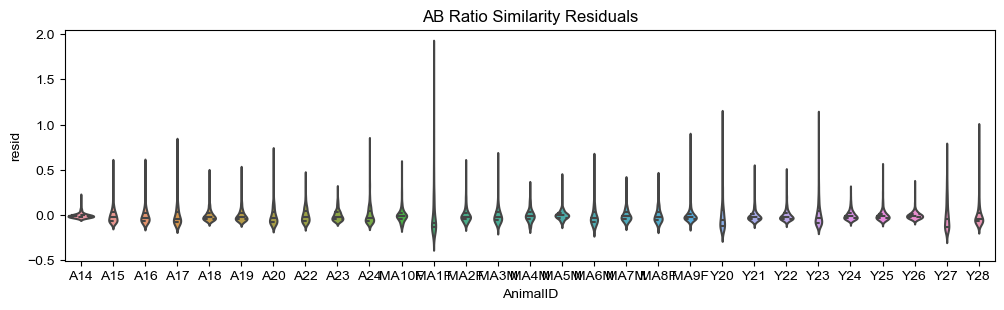

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    A_B_ratio 
No. Observations:      12585      Method:                REML      
No. Groups:            29         Scale:                 0.0028    
Min. group size:       95         Log-Likelihood:        13100.1806
Max. group size:       770        Converged:             Yes       
Mean group size:       434.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.021    0.011 94.419 0.000  1.000  1.042
C(AgeGroup)[T.2.0]        0.004    0.016  0.260 0.795 -0.028  0.036
C(AgeGroup)[T.3.0]        0.047    0.013  3.584 0.000  0.021  0.072
C(Sex)[T.M]              -0.007    0.017 -0.392 0.695 -0.040  0.027
C(Cohort)[T.D]            0.016    0.021  0.763 0.446 -0.025  0

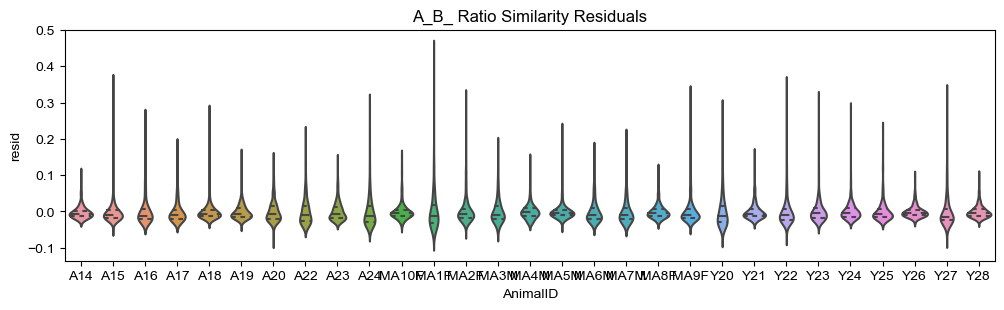

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    AB_ratio  
No. Observations:      12585      Method:                REML      
No. Groups:            29         Scale:                 0.0034    
Min. group size:       95         Log-Likelihood:        11949.7910
Max. group size:       770        Converged:             Yes       
Mean group size:       434.0                                       
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.020    0.012 85.930 0.000  0.997  1.043
C(AgeGroup)[T.2.0]        0.012    0.018  0.668 0.504 -0.023  0.047
C(AgeGroup)[T.3.0]        0.033    0.014  2.298 0.022  0.005  0.061
C(Sex)[T.M]              -0.015    0.019 -0.784 0.433 -0.051  0.022
C(Cohort)[T.D]            0.015    0.023  0.671 0.502 -0.030  0

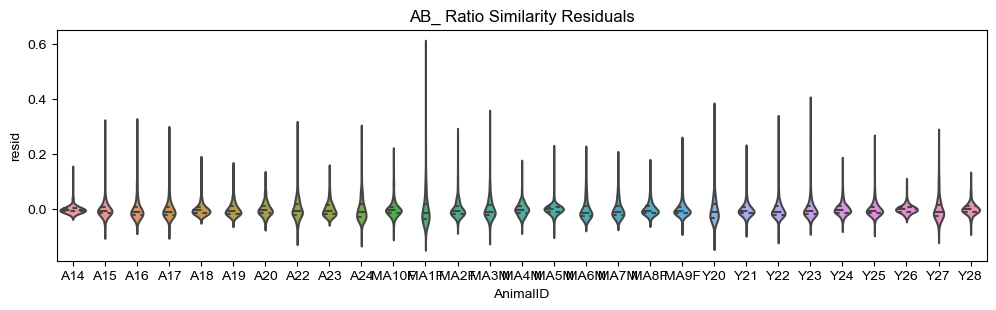

In [76]:
''' LMMs for Similarity Ratios '''        
#gather dependent variables into lists
ABratio = list(np.concatenate((aABratio, maABratio, yABratio)))
A_B_ratio = list(np.concatenate((aA_B_ratio, maA_B_ratio, yA_B_ratio)))
AB_ratio = list(np.concatenate((aAB_ratio, maAB_ratio, yAB_ratio)))

tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, EngageA, EngageB, EngageA_, EngageB_, ABratio, A_B_ratio, AB_ratio))
tuples
df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID','Sex', 'AgeGroup', 'Cohort','EngageA', 'EngageB', 'EngageA_', 'EngageB_','ABratio','A_B_ratio','AB_ratio'])

#handle NaNs
df = df.dropna(axis = 0)

# ABratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB = smf.mixedlm('ABratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB.summary())
print(mAB.wald_test_terms(scalar = False))

#plot residuals
df['resid'] = mAB.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB Ratio Similarity Residuals')
plt.show()

# A_B_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mA_B_ = smf.mixedlm('A_B_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mA_B_.summary())
print(mA_B_.wald_test_terms(scalar = False))

df['resid'] = mA_B_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('A_B_ Ratio Similarity Residuals')
plt.show()

# AB_ratio Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mAB_ = smf.mixedlm('AB_ratio ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml= True)
print(mAB_.summary())
print(mAB_.wald_test_terms(scalar = False))

df['resid'] = mAB_.resid
fig, ax = plt.subplots(figsize = (12,3))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('AB_ Ratio Similarity Residuals')
plt.show()

In [77]:
''' Get fitted session averages '''

df['mAB_fitted'] = mAB_.fittedvalues
resultA_ = df.groupby(by = ['AnimalID','Session'], as_index = False)['mAB_fitted'].aggregate('mean')
#print(resultA_)
seshAanimal = np.asarray(resultA_['AnimalID'])
seshAcount = np.asarray(resultA_['Session'])
seshA_mean = np.asarray(resultA_['mAB_fitted'])

slocstab5A_fitted_seg_aged = [[] * r for i in range(r)]
slocstab5A_fitted_seg_MA = [[] * r for i in range(r)]
slocstab5A_fitted_seg_young = [[] * r for i in range(r)]

sessionAcount_fitted_aged = [[] * r for i in range(r)]
sessionAcount_fitted_MA = [[] * r for i in range(r)]
sessionAcount_fitted_young = [[] * r for i in range(r)]

for m, session in zip(mice, sessions): 
    
    animalidx = np.where(seshAanimal == m)[0][0]
    sessiona_idx = np.where(seshAanimal == m)[0]
    
    if m in SM_aged_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_aged[idx] = np.append(slocstab5A_fitted_seg_aged[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_aged[idx] = np.append(sessionAcount_fitted_aged[idx], c - 1)
   
    elif m in SM_MA_mice:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_MA[idx] = np.append(slocstab5A_fitted_seg_MA[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_MA[idx] = np.append(sessionAcount_fitted_MA[idx], c - 1)
             
    else:
        for i, c in enumerate(seshAcount[sessiona_idx]):
            idx = c.astype(int) - 1
            slocstab5A_fitted_seg_young[idx] = np.append(slocstab5A_fitted_seg_young[idx],seshA_mean[sessiona_idx][i])
            sessionAcount_fitted_young[idx] = np.append(sessionAcount_fitted_young[idx], c - 1)
            


aged, MA, young mice on day 1
10 10 9

aged, MA, young mice on day 2
10 10 9

aged, MA, young mice on day 3
10 10 9

aged, MA, young mice on day 4
9 10 9

aged, MA, young mice on day 5
8 9 9

aged, MA, young mice on day 6
8 9 9


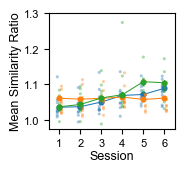

In [80]:
''' Plot Figure 2j '''
f, ax = plt.subplots(1, 1, figsize=(1.625, 1.5), sharey = True)

g = sns.pointplot(x = df['Session'], y = mAB_.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order, ax = ax, scale = 0.5)
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([-0.5,5.5])
ax.set_ylim([0.975,1.3])
ax.tick_params(labelsize = 8)
ax.set_ylabel('Mean Similarity Ratio', fontsize=9, labelpad=1)
ax.set_xlabel('Session', fontsize=9, labelpad=1)
g.legend_.remove()

#scatter plot actual raw data:
for i in range(0,len(slocstab5A_fitted_seg_aged)):
    
    print('\naged, MA, young mice on day ' + str(i + 1))
    print(len(sessionAcount_fitted_aged[i]),len(sessionAcount_fitted_MA[i]), len(sessionAcount_fitted_young[i]))
    
    ax.scatter(sessionAcount_fitted_aged[i] + 0.1, slocstab5A_fitted_seg_aged[i], s = 5, alpha = 0.4, c = 'C1', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_MA[i], slocstab5A_fitted_seg_MA[i], s = 5, alpha = 0.4, c = 'C2', edgecolor = 'none')
    ax.scatter(sessionAcount_fitted_young[i] - 0.1, slocstab5A_fitted_seg_young[i], s = 5, alpha = 0.4, c = 'C0', edgecolor = 'none')

for l in g.lines:
    plt.setp(l,linewidth = 0.75)

#ax.legend(loc = 4, fontsize = 9)
#plt.savefig(save_folder + 'time_altdisc_fitted_composite_LMM.png', dpi=400, bbox_inches='tight')
#plt.savefig(save_folder + 'time_altdisc_fitted_composite_LMM.svg', dpi=400, bbox_inches='tight')
plt.show()

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.5539048353395918 0.5310442301217525 0.41851045664332115 0.5066171681042697
P [Young, MA, Aged, All]: 
1.3929565184938963e-05 1.7978433166009805e-05 0.0014737603869164992 2.841510712704169e-12

Association btwn Young, MA, Aged, & All Performance & Variable of Interest:
R [Young, MA, Aged, All]: 
0.10164590777249281 0.5994224251320062 0.8155604003441432 0.6589365457674428
P [Young, MA, Aged, All]: 
0.7947032434800144 0.08800890784265894 0.01359589786515315 0.0002516297779274751


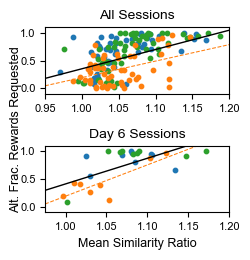

In [81]:
''' Plot Figure 2k '''
### A_ vs. REQ ALT RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

res = stats.linregress(sAB_ratio[~np.isnan(sAB_ratio)],reqalt_rates[~np.isnan(sAB_ratio)])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('Association btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)
 
#plot all session correlations
fig, ax = plt.subplots(2,1, figsize = (2.5,2.7))
ax[0].set_title('All Sessions', fontsize = 10)

ax[0].scatter(sAB_ratio[y_sindspatial],reqalt_rates[y_sindspatial], color = 'C0', label = 'Young', s = 10)
ax[0].scatter(sAB_ratio[ma_sindspatial],reqalt_rates[ma_sindspatial], color = 'C2', label = 'MA', s = 10)
ax[0].scatter(sAB_ratio[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])],reqalt_rates[age_sindspatial][~np.isnan(sAB_ratio[age_sindspatial])], color = 'C1', s = 10)

ax[0].set_ylim([-0.1,1.1])
ax[0].set_xlim([0.95,1.2])
ax[0].tick_params(labelsize = 8)
ax[0].set_yticks([0,0.5,1.0])
X_plot = np.linspace(ax[0].get_xlim()[0],ax[0].get_xlim()[1],100)
ax[0].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[0].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

#day 6 data
### ALT Stability vs. REQ RATES
#Linear regression
res = stats.linregress(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])])
yslope1 = res.slope; yint1 = res.intercept; yr1 = res.rvalue; yp1 = res.pvalue

res = stats.linregress(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])])
maslope1 = res.slope; maint1 = res.intercept; mar1 = res.rvalue ; map1 = res.pvalue

res = stats.linregress(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])])
aslope1 = res.slope; aint1 = res.intercept; ar1 = res.rvalue ; ap1 = res.pvalue

allidx = np.concatenate((y_sind6th[~np.isnan(sAB_ratio[y_sind6th])],ma_sind6th[~np.isnan(sAB_ratio[ma_sind6th])],age_sind6th[~np.isnan(sAB_ratio[age_sind6th])]))
res = stats.linregress(sAB_ratio[allidx],reqalt_rates[allidx])
allslope1 = res.slope; allint1 = res.intercept; allr1 = res.rvalue; allp1 = res.pvalue

print('\nAssociation btwn Young, MA, Aged, & All Performance & Variable of Interest:')
print('R [Young, MA, Aged, All]: ')
print(yr1, mar1, ar1, allr1)
print('P [Young, MA, Aged, All]: ')
print(yp1, map1, ap1, allp1)

ax[1].set_title('Day 6 Sessions', fontsize = 10)
ax[1].scatter(sAB_ratio[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])],reqalt_rates[y_sind6th][~np.isnan(sAB_ratio[y_sind6th])], color = 'C0', s = 10)
ax[1].scatter(sAB_ratio[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])],reqalt_rates[ma_sind6th][~np.isnan(sAB_ratio[ma_sind6th])], color = 'C2', s = 10)
ax[1].scatter(sAB_ratio[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])],reqalt_rates[age_sind6th][~np.isnan(sAB_ratio[age_sind6th])], color = 'C1', s = 10)
#ax[1].set_xlabel('Avg. Stability in A_ & B_')
#ax[1].set_ylabel('Fraction Rewards Requested')
ax[1].set_ylim([-0.1,1.1])
ax[1].set_xlim([0.975,1.2])
ax[1].set_yticks([0,0.5,1.0])
ax[1].tick_params(labelsize = 8)
X_plot = np.linspace(ax[1].get_xlim()[0],ax[1].get_xlim()[1],100)
ax[1].set_xlabel('Mean Similarity Ratio', fontsize = 9)
#ax[1].plot(X_plot, yslope1*X_plot + yint1, '--', color = 'C0', label = 'Young Fit')
#ax[1].plot(X_plot, maslope1*X_plot + maint1, '--', color = 'C2', label = 'MA Fit')
ax[1].plot(X_plot, aslope1*X_plot + aint1, '--', linewidth = 0.75, color = 'C1', label = 'Aged')
ax[1].plot(X_plot, allslope1*X_plot + allint1, '-', linewidth = 1, color = 'k', label = 'All Ages')

plt.tight_layout()
fig.supylabel('Alt. Frac. Rewards Requested', fontsize = 9)
#plt.savefig(save_folder + 'alldays_disc_correlation.png', dpi = 400, bbox_inches = 'tight')
#plt.savefig(save_folder + 'alldays_disc_correlation.svg', dpi = 400, bbox_inches = 'tight')
plt.show()